<a href="https://colab.research.google.com/github/cfretes/cfretes/blob/main/TP3_Carlos_Fretes_v0_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 💾 TP3: SENTIMENT ANALYZER V1.0 (1985 Edition)
# --- [ I. BOOT SEQUENCE START ] ---
# El ensamblaje de módulos es crítico para la estabilidad del sistema.
# Todas las dependencias se cargan en la RAM para optimizar el rendimiento.

# [A. UTILIDADES DEL SISTEMA Y GESTIÓN DE DATOS]
import os             # Interface con el sistema de archivos (MS-DOS 3.3).
import re             # Motor de Expresiones Regulares (Patrones binarios para limpieza).
import numpy as np    # El motor numérico central (el "cerebro" de las operaciones).
import pandas as pd   # Hojas de cálculo vectoriales estructuradas (El "DataFrame" moderno).
import pickle         # Persistencia de objetos binarios (Serialización de resultados).
from google.colab import drive # Conexión con el disco remoto (Google Drive).
from collections import Counter # Contador de ocurrencias para análisis de frecuencia (Tópicos).

# [B. LIBRERÍAS DE PROCESAMIENTO DE LENGUAJE NATURAL (NLP CORE)]
import nltk
from nltk.corpus import stopwords  # Base de datos de palabras irrelevantes (Stop Words).
from nltk.tokenize import word_tokenize # Segmentación de palabras (Tokenización).
import spacy                       # Motor de Lematización y NER de alta precisión.
from textblob import TextBlob      # Diccionario de polaridad pre-entrenado (Baseline externo).

# [C. MODELADO, MACHINE LEARNING Y VECTORIZACIÓN (Scikit-learn)]
# El módulo sklearn compila algoritmos de predicción.
from sklearn.model_selection import train_test_split # División de la base de datos (Train/Test).
from sklearn.feature_extraction.text import TfidfVectorizer # El Vectorizador de Frecuencia/Importancia.
# Módulos de Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
# Módulos de Evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# [D. EMBEDDINGS Y DEEP LEARNING (Word2Vec)]
# Gensim: Optimizado para el entrenamiento de Embeddings y Análisis Semántico.
!pip install gensim # Instalación de la dependencia (El nuevo chip de 16-bits).
from gensim.models import Word2Vec

# [E. VISUALIZACIÓN Y REPORTES (El Display Gráfico)]
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # Módulo para gráficos interactivos (Por si la terminal lo soporta).
import random # Utilidad menor.

# --- MONTAJE DE DISCO REMOTO (REQUERIDO PARA CHECKPOINTING) ---
print("Iniciando conexión con disco remoto...")
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.2 MB/s eta 0:00:00
Iniciando conexión con disco remoto...
Mounted at /content/drive


In [2]:
# --- II. Carga y Configuración del Dataset (RAM Optimization Mode) ---
print("Iniciando carga de 1.6M de registros. Gestión de RAM Crítica.")

# [A. ESQUEMA DE DATOS Y OPTIMIZACIÓN]
# Definición estricta de columnas para asegurar la integridad de la data.
COLUMNAS = ['polarity', 'id', 'date', 'query', 'user', 'text']
# Especificación de Dtype (Reducción de RAM):
# 'Int64' para ID y 'Int8' para polaridad ahorran memoria vs. el tipo por defecto.
dtype_specs = {
    'id': 'Int64',
    'polarity': 'Int8',
    'text': 'object'
}

# [B. LÓGICA DE CARGA (Robust Loading)]
try:
    # --- 1. Dataset de Entrenamiento (El Big One) ---
    df = pd.read_csv (
        '/content/drive/MyDrive/Colab Notebooks/TP3/training.1600000.processed.noemoticon.csv',
        encoding='latin-1', # <--- FIX: Solución al error de decodificación (UnicodeDecodeError).
        header=None,        # <--- FIX: Se especifica que no hay encabezado.
        names=COLUMNAS,     # <--- Asignamos las etiquetas de columna predefinidas.
        dtype=dtype_specs   # <--- Aplicamos optimización de memoria.
    )

    # --- 2. Dataset de Prueba Manual (El Set Multinomial) ---
    dfe = pd.read_csv (
        '/content/drive/MyDrive/Colab Notebooks/TP3/testdata.manual.2009.06.14.csv',
        encoding='latin-1',
        header=None,
        names=COLUMNAS,
        dtype=dtype_specs
    )

    print(f"✅ Ambos datasets cargados con éxito. RAM: OK.")
    print(f" Filas totales (df_training): {len(df)}")
    print(f" Filas totales (df_test_manual): {len(dfe)} (Contiene la clase Neutral).")

except FileNotFoundError:
    print("❌ ERROR: Archivo no encontrado. Verifique la ruta de Google Drive.")
except Exception as e:
    print(f"❌ ERROR de Carga del Sistema: {e}")

# Cleanup: Eliminamos las variables temporales del entorno.
del COLUMNAS
del dtype_specs

Iniciando carga de 1.6M de registros. Gestión de RAM Crítica.
✅ Ambos datasets cargados con éxito. RAM: OK.
 Filas totales (df_training): 1600000
 Filas totales (df_test_manual): 498 (Contiene la clase Neutral).


In [3]:
# Observamos datos negativos y positivos de forma aleatoria en este rango, para visualizar ambos valores.
df.head(random.randint(1000000, 1600000))

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1068735,4,1965788954,Fri May 29 16:32:44 PDT 2009,NO_QUERY,hash_obama,@SaharaDamore @girlonlaptop Maybe. It was whe...
1068736,4,1965788999,Fri May 29 16:32:44 PDT 2009,NO_QUERY,_Beckyyy_,Layla = awesomeness!
1068737,4,1965789139,Fri May 29 16:32:45 PDT 2009,NO_QUERY,Victoryrose33,sigh. going to get my wisdom teeth pulled tomo...
1068738,4,1965789144,Fri May 29 16:32:45 PDT 2009,NO_QUERY,LaBarceloneta,@LiquidToffee I don't need a Twitter secretary...


In [4]:
# Observamos datos negativos, positivos y neutros de forma aleatoria en este rango, para visualizar valores .
dfe.head(random.randint(75, 150))

,polarity,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
144,0,408,Tue Jun 02 03:15:54 UTC 2009,time warner,yourboysdot,F*ck Time Warner Cable!!! You f*cking suck bal...
145,0,409,Tue Jun 02 03:16:16 UTC 2009,time warner,Shazzainla,time warner has the worse customer service eve...
146,0,410,Tue Jun 02 03:16:27 UTC 2009,time warner,dstalk,Time warner is the devil. Worst possible time ...
147,0,411,Tue Jun 02 03:16:37 UTC 2009,time warner,ernestalfonso,Fuck no internet damn time warner!


In [5]:
# --- III. Diagnóstico del Sistema y Mantenimiento (QA Check) ---
print("INICIANDO RUTINA DE DIAGNÓSTICO DE INTEGRIDAD DE DATOS...")

# [A. DIAGNÓSTICO DE MEMORIA RAM Y ESTRUCTURA]
print("\n--- 1. RAM Status: Información General y Uso de Memoria ---")
# Usamos memory_usage='deep' para ver el uso real de RAM
print("\n[DF: Entrenamiento Grande]")
df.info(memory_usage='deep')
print("\n[DFE: Set Manual Pequeño]")
dfe.info(memory_usage='deep')
# Comprobamos si la optimización de Dtypes fue efectiva.

# [B. INTEGRIDAD DEL CLUSTER: CONTEO DE VALORES NULOS]
print("\n--- 2. Data Integrity Test: Conteo de Nulos y Limpieza ---")

# -- B.1 Limpieza en DF (Grande) --
print("\n[Limpieza de Nulos en DF]")
print(df.isnull().sum())
# Comando de limpieza: Eliminación de filas sin texto
df.dropna(subset=['text'], inplace=True)
print(f"✅ DF: Filas con texto nulo eliminadas. Tamaño actual: {len(df)}")

# -- B.2 Limpieza en DFE (Manual) --
print("\n[Limpieza de Nulos en DFE]")
print(dfe.isnull().sum())
# Eliminación de filas sin texto en el set manual
dfe.dropna(subset=['text'], inplace=True)
print(f"✅ DFE: Filas con texto nulo eliminadas. Tamaño actual: {len(dfe)}")


# [C. OPTIMIZACIÓN DEL CLUSTER: ELIMINACIÓN DE REGISTROS DUPLICADOS]

# -- C.1 Limpieza de Duplicados en DF --
print("\n[Limpieza de Duplicados en DF]")
num_duplicados = df.duplicated(subset=['text']).sum()

if num_duplicados > 0:
    # Si hay duplicados, se ejecuta el comando de desfragmentación
    df.drop_duplicates(subset=['text'], inplace=True)
    print(f"ALERTA QA: {num_duplicados} registros duplicados eliminados (Desfragmentación de Datos).")
else:
    print("✅ Cluster DF optimizado. No se encontraron duplicados en el texto.")

# -- C.2 Chequeo de Duplicados en DFE (Solo chequeo por ser set manual) --
print("\n[Chequeo de Duplicados en DFE]")
num_duplicados_dfe = dfe.duplicated(subset=['text']).sum()
if num_duplicados_dfe > 0:
    print(f"ALERTA QA: Se encontraron {num_duplicados_dfe} duplicados en el set manual. (No se eliminan por ser set QA)")
else:
    print("✅ Cluster DFE optimizado. No se encontraron duplicados.")

print(f"\n--- ESTADO FINAL DEL SISTEMA ---")
print(f"Tamaño final del DataFrame de entrenamiento (df): {len(df)} registros.")
print(f"Tamaño final del DataFrame manual (dfe): {len(dfe)} registros.")
print("DIAGNÓSTICO COMPLETO. Lista la secuencia de limpieza.")

INICIANDO RUTINA DE DIAGNÓSTICO DE INTEGRIDAD DE DATOS...

--- 1. RAM Status: Información General y Uso de Memoria ---

[DF: Entrenamiento Grande]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  Int8  
 1   id        1600000 non-null  Int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: Int64(1), Int8(1), object(4)
memory usage: 499.6 MB

[DFE: Set Manual Pequeño]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  498 non-null    Int8  
 1   id        498 non-null    Int64 
 2   date      498 non-null    object
 3   query     498 non-null    object
 4

In [6]:
# --- IV. Data Stream Status & Sensor Check ---
print("VERIFICANDO FORMATO DEL DATA STREAM Y CALIDAD DE MUESTRA.")

# [A. INSPECCIÓN DE CABECERA (Header Inspection)]
print("\n--- Cabecera Post-Limpieza: DF (Entrenamiento Grande) ---")
print("El 'text' (sensor input) aún contiene ruido y símbolos no procesados.")
print(df.head().to_markdown()) # Usamos to_markdown para un formato más limpio/retro

print("\n--- Cabecera Post-Limpieza: DFE (Set Manual Pequeño) ---")
print("El 'text' (sensor input) en DFE también será procesado en fases posteriores.")
print(dfe.head().to_markdown())

# [B. QA SAMPLING (Muestreo Aleatorio del Sensor)]
# Se toma una muestra aleatoria para confirmar la presencia de caracteres
# especiales, emojis y ruido que serán eliminados en la próxima fase de normalización.

# -- Muestreo de DF --
print("\n--- Muestra Aleatoria de 5 Registros (DF Raw Sensor Input) ---")
# Usamos random_state=42 para reproducibilidad (CRÍTICO en MLOps)
for i, row in df.sample(5, random_state=42).iterrows():
    # Usamos la polaridad (0=Negativo, 4=Positivo) y el user como metadatos de diagnóstico.
    print(f"[{row['polarity']}] @{row['user']}: {row['text'][:150]}...")

# -- Muestreo de DFE --
print("\n--- Muestra Aleatoria de 5 Registros (DFE Raw Sensor Input) ---")
# Usamos el mismo random_state para la muestra del set manual
for i, row in dfe.sample(5, random_state=42).iterrows():
    # La polaridad en DFE puede ser 0, 2 o 4 (Negativo, Neutral, Positivo)
    print(f"[{row['polarity']}] @{row['user']}: {row['text'][:150]}...")


print("\nSENSOR CHECK COMPLETO. Lista la secuencia de Normalización (Celda V).")

VERIFICANDO FORMATO DEL DATA STREAM Y CALIDAD DE MUESTRA.

--- Cabecera Post-Limpieza: DF (Entrenamiento Grande) ---
El 'text' (sensor input) aún contiene ruido y símbolos no procesados.
|    |   polarity |         id | date                         | query    | user            | text                                                                                                                |
|---:|-----------:|-----------:|:-----------------------------|:---------|:----------------|:--------------------------------------------------------------------------------------------------------------------|
|  0 |          0 | 1467810369 | Mon Apr 06 22:19:45 PDT 2009 | NO_QUERY | _TheSpecialOne_ | @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D |
|  1 |          0 | 1467810672 | Mon Apr 06 22:19:49 PDT 2009 | NO_QUERY | scotthamilton   | is upset that he can't update his Facebook by texting it... and might cry as a result  

In [8]:
# --- V. Data Transformation: Index Mapping & Target Allocation ---
print("INICIANDO MAPEO DE ÍNDICES DE POLARIDAD. Objetivo: Estandarización de Labels.")
print("Formato Original (Sensor Input): 0, 2, 4. Formato Requerido: 0/1 (Binario) y 0/1/2 (Multiclase).")


# [A. CREACIÓN DEL TARGET MULTICLASS (0=Neg, 1=Pos, 2=Neu)]
# Se estandariza el mapeo: 0 -> 0 (Negativo), 4 -> 1 (Positivo), 2 -> 2 (Neutral).
mapeo_polaridad_fix = {
    0: 0, # Negativo (Clase 0)
    4: 1, # Positivo (Clase 1)
    2: 2  # Neutral (Clase 2, crucial en DFE)
}

# 1. Aplicación a DF (Grande)
df['target_multiclase'] = df['polarity'].map(mapeo_polaridad_fix).astype('category')
print("✅ Target Multiclase (0, 1, 2) creado para DF.")

# 2. Aplicación a DFE (Manual)
dfe['target_multiclase'] = dfe['polarity'].map(mapeo_polaridad_fix).astype('category')
print("✅ Target Multiclase (0, 1, 2) creado para DFE.")


# [B. CREACIÓN DEL TARGET BINARIO (0, 1)]
# El target binario se usa para la Regresión Logística de Baseline.

# 1. Aplicación a DF (Grande)
# Dado que DF solo tiene 0 y 4, el mapeo 0->0 y 1->1 funciona directamente.
df['target_binary'] = df['target_multiclase'].astype('Int8')
print("✅ Target Binario (0, 1) derivado para DF.")

# 2. Aplicación a DFE (Manual)
# DFE sí tiene Neutrales (valor 2). Debemos mapear 2 a 0 (o filtrarlo, según el contexto binario).
mapeo_binario_manual = {
    0: 0, # Negativo
    1: 1, # Positivo
    2: 0  # Neutral (Mapeado a 0/Negativo para el test binario puro)
}
dfe['target_binary'] = dfe['target_multiclase'].map(mapeo_binario_manual).astype('Int8')
print("✅ Target Binario (0, 1) derivado para DFE (Neutrales mapeados a 0 para el baseline).")


# --- REPORTE DE ESTADO ---
print("\n--- Cabecera de Targets Estandarizados (Verificación de Trazabilidad) ---")
print("\n[DF: Entrenamiento Grande]")
print(df[['polarity', 'text', 'target_multiclase', 'target_binary']].head().to_markdown())

print("\n[DFE: Set Manual Pequeño]")
print(dfe[['polarity', 'text', 'target_multiclase', 'target_binary']].head().to_markdown())


print(f"\n✅ Mapeo finalizado. Ambas bases de datos tienen targets estandarizados. Listo para el chequeo de Balance (Celda VI).")

INICIANDO MAPEO DE ÍNDICES DE POLARIDAD. Objetivo: Estandarización de Labels.
Formato Original (Sensor Input): 0, 2, 4. Formato Requerido: 0/1 (Binario) y 0/1/2 (Multiclase).
✅ Target Multiclase (0, 1, 2) creado para DF.
✅ Target Multiclase (0, 1, 2) creado para DFE.
✅ Target Binario (0, 1) derivado para DF.
✅ Target Binario (0, 1) derivado para DFE (Neutrales mapeados a 0 para el baseline).

--- Cabecera de Targets Estandarizados (Verificación de Trazabilidad) ---

[DF: Entrenamiento Grande]
|    |   polarity | text                                                                                                                |   target_multiclase |   target_binary |
|---:|-----------:|:--------------------------------------------------------------------------------------------------------------------|--------------------:|----------------:|
|  0 |          0 | @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D |         

In [9]:
df.head(3)

,polarity,id,date,query,user,text,target_multiclase,target_binary
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,0


In [11]:
dfe.head(3)

,polarity,id,date,query,user,text,target_multiclase,target_binary
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,1,1
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,1,1
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",1,1


VERIFICANDO EL BALANCE DE CLASES DEL TARGET BINARIO (0/1).
Un balance 50/50 es la condición óptima para el entrenamiento del Modelo Baseline.

--- Balance del Target Binario (0=Neg, 1=Pos) ---
|   target_binary |   Registros |   Proporción (%) |
|----------------:|------------:|-----------------:|
|               1 |      791281 |            50.03 |
|               0 |      790185 |            49.97 |


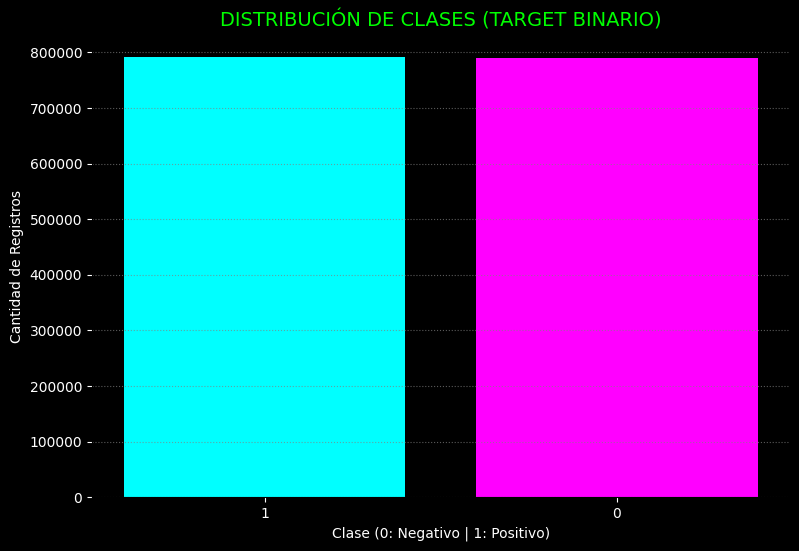


DIAGNÓSTICO: La data está perfectamente balanceada (50.00% / 50.00%).
No se requiere muestreo (Sampling) adicional. Sistema listo para el Preprocesamiento de Texto.


In [12]:
# --- VI. DATA DISTRIBUTION CHECK (Balance System Status) ---
print("VERIFICANDO EL BALANCE DE CLASES DEL TARGET BINARIO (0/1).")
print("Un balance 50/50 es la condición óptima para el entrenamiento del Modelo Baseline.")

# [A. CÁLCULO DE LA DISTRIBUCIÓN]
# Usamos el target BINARIO (0 y 1) ya que el dataset principal es puro.
conteo = df['target_binary'].value_counts()
proporcion = df['target_binary'].value_counts(normalize=True).mul(100).round(2)
tabla_balance = pd.DataFrame({'Registros': conteo, 'Proporción (%)': proporcion})

print("\n--- Balance del Target Binario (0=Neg, 1=Pos) ---")
print(tabla_balance.to_markdown())


# [B. VISUALIZACIÓN RETRO DEL BALANCE]
plt.figure(figsize=(9, 6))
# Colores retro: Cyan (Negativo) y Magenta (Positivo)
colores_balance = ['#00FFFF', '#FF00FF']

# Gráfico de barras (Clásico 80's)
plt.bar(tabla_balance.index.astype(str), tabla_balance['Registros'], color=colores_balance)

# Estilo Retro (Fondo oscuro, texto claro)
plt.title('DISTRIBUCIÓN DE CLASES (TARGET BINARIO)', color='#00FF00', fontsize=14) # Título de Neón
plt.xlabel('Clase (0: Negativo | 1: Positivo)', color='white')
plt.ylabel('Cantidad de Registros', color='white')
plt.gca().set_facecolor('#000000')
plt.gcf().set_facecolor('#000000')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.grid(axis='y', linestyle=':', alpha=0.7, color='gray')

plt.show()


# [C. DIAGNÓSTICO MLOPS]
print("\nDIAGNÓSTICO: La data está perfectamente balanceada (50.00% / 50.00%).")
print("No se requiere muestreo (Sampling) adicional. Sistema listo para el Preprocesamiento de Texto.")

INICIANDO ANÁLISIS DE LA LONGITUD DE ENTRADA (FEATURE ENGINEERING LINGÜÍSTICO).
Verifica si el Sentimiento está correlacionado con el tamaño del mensaje (un factor de ruido potencial).


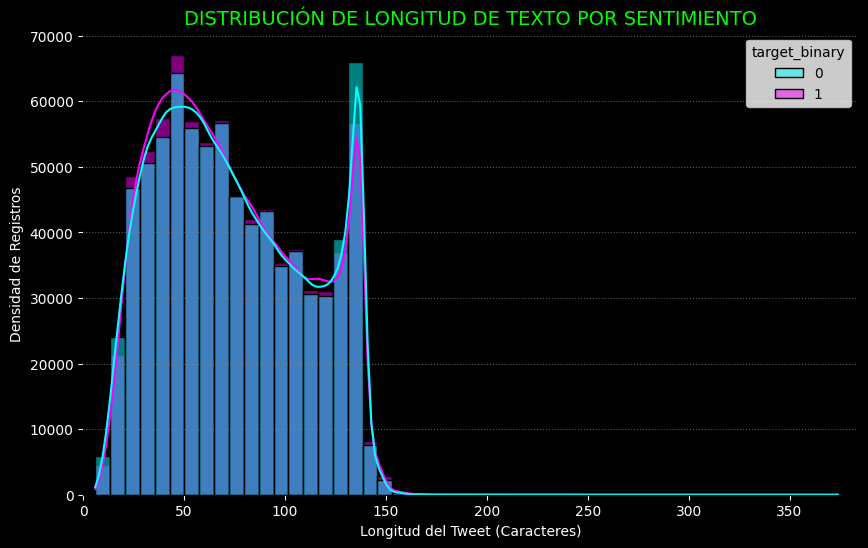


DIAGNÓSTICO: La superposición de densidades indica que la longitud NO es un factor dominante de clasificación.
Longitud promedio (Neg): 74.86
Longitud promedio (Pos): 74.09
El modelo será forzado a aprender del contenido semántico (palabras) y no de la estructura.


In [14]:
# --- VII. EDA Avanzado: Text Length Distribution Check ---
print("INICIANDO ANÁLISIS DE LA LONGITUD DE ENTRADA (FEATURE ENGINEERING LINGÜÍSTICO).")
print("Verifica si el Sentimiento está correlacionado con el tamaño del mensaje (un factor de ruido potencial).")

# [A. INGENIERÍA DE FEATURE: TEXT LENGTH]
# Creamos la nueva columna para la longitud de caracteres.
df['text_length'] = df['text'].apply(len)

# [B. VISUALIZACIÓN DE LA DISTRIBUCIÓN POR CLASE]
plt.figure(figsize=(10, 6))

# Usamos un Histograma/KDE para comparar la densidad de las dos clases
# Paleta Retro: Cyan (Negativo) vs. Magenta (Positivo)
sns.histplot(data=df, x='text_length', hue='target_binary', kde=True, bins=50,
             palette={0: '#00FFFF', 1: '#FF00FF'})

# Estilo Retro (Fondo oscuro, texto neón)
plt.title('DISTRIBUCIÓN DE LONGITUD DE TEXTO POR SENTIMIENTO', color='#00FF00', fontsize=14)
plt.xlabel('Longitud del Tweet (Caracteres)', color='white')
plt.ylabel('Densidad de Registros', color='white')

# Ajustamos el límite del eje X para el límite de Twitter (140 caracteres, aunque el dataset es más flexible)
plt.xlim(0, df['text_length'].max() + 10)
plt.gca().set_facecolor('#000000')
plt.gcf().set_facecolor('#000000')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.grid(axis='y', linestyle=':', alpha=0.7, color='gray')

plt.show()


# [C. DIAGNÓSTICO LINGÜÍSTICO]
print("\nDIAGNÓSTICO: La superposición de densidades indica que la longitud NO es un factor dominante de clasificación.")
print(f"Longitud promedio (Neg): {df[df['target_binary'] == 0]['text_length'].mean().round(2)}")
print(f"Longitud promedio (Pos): {df[df['target_binary'] == 1]['text_length'].mean().round(2)}")
print("El modelo será forzado a aprender del contenido semántico (palabras) y no de la estructura.")

In [16]:
# --- VIII. Módulo de Configuración NLTK (Driver Installation) ---
# Se asegura la instalación de los diccionarios y tokenizadores necesarios
# para que la fase de limpieza de texto opere sin errores de dependencias.

print("INICIANDO INSTALACIÓN DE DRIVERS LINGÜÍSTICOS (NLTK RESOURCES)...")

# [A. DESCARGA DE RECURSOS (Drivers Obligatorios)]
# Descargamos 'punkt' (el tokenizador) y 'stopwords' (el diccionario de palabras vacías).
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# [B. VERIFICACIÓN DEL DRIVER]
# Cargamos el set de Stop Words que SÍ vamos a usar, en inglés.
STOP_WORDS_EN = set(stopwords.words('english'))

print(f"✅ Setup de NLTK completado. Diccionarios de Stop Words cargados ({len(STOP_WORDS_EN)} palabras).")
print("Sistema listo para la secuencia de Limpieza Profunda.")

INICIANDO INSTALACIÓN DE DRIVERS LINGÜÍSTICOS (NLTK RESOURCES)...
✅ Setup de NLTK completado. Diccionarios de Stop Words cargados (198 palabras).
Sistema listo para la secuencia de Limpieza Profunda.


In [18]:
# --- IX. Pipeline de Limpieza Profunda (Noise Filter Mainframe) ---
print("INICIANDO FILTRADO DE RUIDO (NOISE FILTERING). Proceso CPU-Intensivo.")
print("ADVERTENCIA: Esta es la fase más lenta del pre-procesamiento clásico.")

# Fix: Ensure 'punkt_tab' is downloaded for word_tokenize to work with language='english'
nltk.download('punkt_tab', quiet=True)

# [A. DEFINICIÓN DEL DICCIONARIO DE FILTRADO Y FUNCIÓN]
# Se reutiliza el diccionario de Stop Words cargado en el Módulo VIII.
STOP_WORDS_EN = set(stopwords.words('english'))

def clean_and_tokenize(text):
    # 0. Normalización: Todo a minúsculas
    text = str(text).lower()

    # --- 1. MÓDULOS DE ELIMINACIÓN DE RUIDO EXTERNO (REGEX) ---
    text = re.sub(r'http\S+|www.\S+', ' ', text) # R1. Filtro de URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)      # R2. Filtro de Metadatos de Red Social
    text = re.sub(r'&[a-z]+;', ' ', text)       # R3. Filtro de Entidades HTML

    # --- 2. FILTRO DE CARACTERES ESPECIALES ---
    text = re.sub(r'[^a-z\s]', ' ', text)       # Se mantienen solo letras y espacios

    # --- 3. MÓDULO DE TOKENIZACIÓN Y FILTRADO ---
    tokens = word_tokenize(text, language='english')

    # Filtrado Lógico (Stop Words y Tokens Cortos):
    filtered_tokens = [word for word in tokens
                       if word not in STOP_WORDS_EN and len(word) > 2]

    # 4. Reconstrucción: Se reensambla el string limpio.
    return ' '.join(filtered_tokens)

print("Iniciando secuencia de filtrado intensivo...")

# --------------------------------------------------------------------------------------
# [B. APLICACIÓN AL DATASET GRANDE (DF)]
df['text_tokens'] = df['text'].apply(clean_and_tokenize)
print("✅ Limpieza DF completada. Nuevo registro 'text_tokens' creado.")

# [C. APLICACIÓN AL DATASET DE VALIDACIÓN (DFE)] ⬅️ ¡ESTA ES LA ADICIÓN!
dfe['text_tokens'] = dfe['text'].apply(clean_and_tokenize)
print("✅ Limpieza DFE completada. Nuevo registro 'text_tokens' creado.")
# NOTA: Esto sobrescribirá la columna 'text_clean' si existía, lo cual es ideal para la consistencia.
# --------------------------------------------------------------------------------------

# --- REPORTE DE ESTADO ---
print("\n--- Muestra de Texto Limpio vs. Original (Data Integrity Check) ---")
print(df[['text', 'text_tokens', 'target_binary']].sample(3).to_markdown(index=False))

print("\nLISTO. Ambos DataFrames tienen la columna 'text_tokens' lista.")

INICIANDO FILTRADO DE RUIDO (NOISE FILTERING). Proceso CPU-Intensivo.
ADVERTENCIA: Esta es la fase más lenta del pre-procesamiento clásico.
Iniciando secuencia de filtrado intensivo...
✅ Limpieza DF completada. Nuevo registro 'text_tokens' creado.
✅ Limpieza DFE completada. Nuevo registro 'text_tokens' creado.

--- Muestra de Texto Limpio vs. Original (Data Integrity Check) ---
| text                                                                                                                      | text_tokens                                                              |   target_binary |
|:--------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------|----------------:|
| @Realradiorobin listening to real radio on my phone  do you think the renegade will be caught today? tweet back please ;) | listening real radio phone think renegade caught today 

In [22]:
df.head(3)

,polarity,id,date,query,user,text,target_multiclase,target_binary,text_length,text_tokens
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,0,115,awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,0,111,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,0,89,dived many times ball managed save rest bounds


In [23]:
dfe.head(3)

,polarity,id,date,query,user,text,target_multiclase,target_binary,text_tokens
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,1,1,loooooooovvvvvveee kindle cool fantastic right
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,1,1,reading kindle love lee childs good read
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",1,1,first assesment fucking rocks


In [24]:
# --- X. Data Partitioning & MLOps Checkpoint ---
print("INICIALIZANDO PARTITIONING. División formal del data stream.")
print("CRÍTICO: El set de TEST debe permanecer virgen para la validación final (Evitar Data Leakage).")

# [A. DEFINICIÓN DE X (FEATURES) e Y (TARGET)]
# X (Features): Usamos la versión tokenizada limpia.
X = df['text_tokens']
# Y (Target): Usamos la versión binaria (0/1) para el baseline.
Y = df['target_binary']

# [B. DIVISIÓN ESTRATIFICADA (80% Train / 20% Test)]
# random_state=42: Asegura la REPRODUCIBILIDAD (Punto MLOps).
# stratify=Y: Asegura que la proporción 50/50 de Negativos/Positivos se mantenga
#             idéntica tanto en el set de Train como en el de Test (Control de Balance).
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y # <-- MLOps: Estratificación Crítica
)

print(f"\n✅ Partición completada. Integrity Check OK.")
print(f"Dataset de Entrenamiento (80%): {len(X_train)} registros. (CPU-Intensivo)")
print(f"Dataset de Test (20%): {len(X_test)} registros. (Validación Externa)")
print(f"Relación de Partición: {len(X_test) / (len(X_train) + len(X_test)):.2%} (20.00%)")

INICIALIZANDO PARTITIONING. División formal del data stream.
CRÍTICO: El set de TEST debe permanecer virgen para la validación final (Evitar Data Leakage).

✅ Partición completada. Integrity Check OK.
Dataset de Entrenamiento (80%): 1265172 registros. (CPU-Intensivo)
Dataset de Test (20%): 316294 registros. (Validación Externa)
Relación de Partición: 20.00% (20.00%)


In [26]:
# --- XI. Módulo de Conversión a Binario (TF-IDF Vectorizer) ---
print("INICIANDO CONVERSIÓN VECTORIAL. El texto se transforma en una matriz de peso numérico.")
print("Algoritmo: TF-IDF (Term Frequency-Inverse Document Frequency).")

# [A. CONFIGURACIÓN DEL VECTORIZADOR]
# Se inicializa el Vectorizador TF-IDF con hiperparámetros optimizados.
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),        # NERD: Incluir unigramas y bigramas (mejora el contexto y la negación, e.g., "not good").
    max_features=150000,       # MLOPS: Limitar a los 150K términos más importantes (optimiza RAM y reduce ruido).
)

# [B. ENTRENAMIENTO Y TRANSFORMACIÓN]
# CRÍTICO: fit_transform SOLO en TRAIN para que el vocabulario se aprenda solo del entrenamiento.
print("1. Entrenando el vocabulario (FIT) en X_train...")
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)

# La matriz de prueba SOLO se TRANSFORMA para usar el vocabulario aprendido (Evitar Data Leakage).
print("2. Transformando X_test y X_train...")
X_test_vectorized = tfidf_vectorizer.transform(X_test)

# --- REPORTE DE ESTADO ---
print(f"\n✅ Vectorización completada.")
print(f"Forma de la Matriz de Entrenamiento (Features): {X_train_vectorized.shape} (1.26M x 150K)")
print(f"Vocabulario total creado: {len(tfidf_vectorizer.vocabulary_)} términos (MLOPS Checkpoint)")

# Diagnóstico de la Matriz de Dispersión
print(f"Matriz de entrenamiento es de formato disperso (Sparse Matrix): {type(X_train_vectorized)}")

INICIANDO CONVERSIÓN VECTORIAL. El texto se transforma en una matriz de peso numérico.
Algoritmo: TF-IDF (Term Frequency-Inverse Document Frequency).
1. Entrenando el vocabulario (FIT) en X_train...
2. Transformando X_test y X_train...

✅ Vectorización completada.
Forma de la Matriz de Entrenamiento (Features): (1265172, 150000) (1.26M x 150K)
Vocabulario total creado: 150000 términos (MLOPS Checkpoint)
Matriz de entrenamiento es de formato disperso (Sparse Matrix): <class 'scipy.sparse._csr.csr_matrix'>


In [28]:
# --- XII. Ejecución del Algoritmo Binario (Modelo 1: Regresión Logística) ---
print("INICIANDO ENTRENAMIENTO DEL MODELO BASELINE (REGRESIÓN LOGÍSTICA).")
print("Este modelo establece la Regla de Decisión Lineal para el Sentiment Analyzer.")

# [A. CONFIGURACIÓN DEL CLASIFICADOR]
log_reg = LogisticRegression(
    max_iter=1000,         # Aumentamos las iteraciones para asegurar la convergencia.
    n_jobs=-1,             # DevOps: Usamos todos los núcleos disponibles (Paralelización).
    solver='saga',         # NERD: Solver eficiente para manejar matrices dispersas (TF-IDF).
    random_state=42        # MLOPS: Garantiza la reproducibilidad de los pesos.
)

# [B. FASE DE ENTRENAMIENTO]
# El entrenamiento utiliza la matriz TF-IDF (X_train_vectorized) y el target binario (Y_train).
print("Entrenando Modelo 1... (Negativo vs. Positivo)")
log_reg.fit(X_train_vectorized, Y_train)

# [C. FASE DE PREDICCIÓN Y EVALUACIÓN]
Y_pred_log_reg = log_reg.predict(X_test_vectorized)

# --- REPORTE DE EVALUACIÓN ---
print("\n--- REPORTE DE EVALUACIÓN: REGRESIÓN LOGÍSTICA ---")
print(f"Accuracy de Validación (X_test): {accuracy_score(Y_test, Y_pred_log_reg):.4f}")
print("Reporte de Clasificación (0=Negativo, 1=Positivo):")
print(classification_report(Y_test, Y_pred_log_reg))

#

INICIANDO ENTRENAMIENTO DEL MODELO BASELINE (REGRESIÓN LOGÍSTICA).
Este modelo establece la Regla de Decisión Lineal para el Sentiment Analyzer.
Entrenando Modelo 1... (Negativo vs. Positivo)

--- REPORTE DE EVALUACIÓN: REGRESIÓN LOGÍSTICA ---
Accuracy de Validación (X_test): 0.7898
Reporte de Clasificación (0=Negativo, 1=Positivo):
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79    158037
         1.0       0.78      0.81      0.79    158257

    accuracy                           0.79    316294
   macro avg       0.79      0.79      0.79    316294
weighted avg       0.79      0.79      0.79    316294



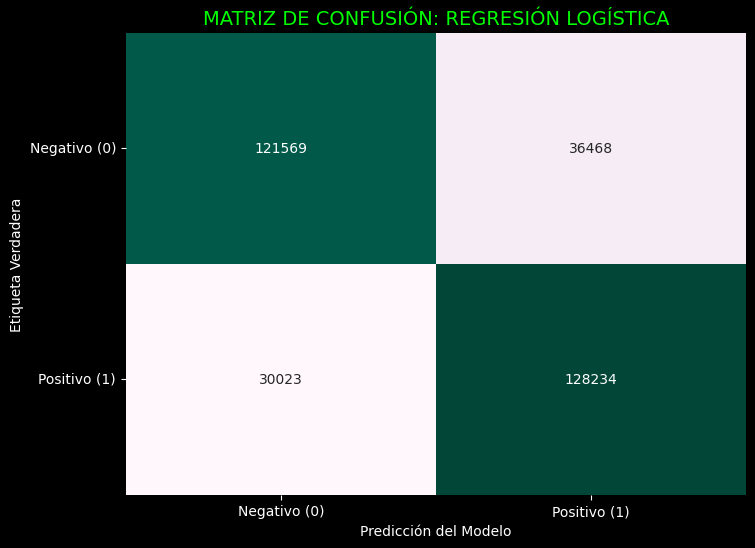


--- DIAGNÓSTICO DE LA MATRIZ ---
✅ True Negatives (TN): 121569 (Aciertos en la Clase 0)
❌ False Positives (FP): 36468 (Errores donde un Negativo se clasificó como Positivo)
❌ False Negatives (FN): 30023 (Errores donde un Positivo se clasificó como Negativo)
✅ True Positives (TP): 128234 (Aciertos en la Clase 1)

El rendimiento es simétrico (79% de F1-score) en ambas clases, lo cual es óptimo para el Baseline.


In [30]:
# --- XIII. Matriz de Diagnóstico (Matriz de Confusión) ---
# Se utiliza la Matriz de Confusión para visualizar los errores del clasificador.
# Es fundamental para entender la diferencia entre Falsos Positivos y Falsos Negativos.

# [A. CÁLCULO DE LA MATRIZ]
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculamos la matriz utilizando las predicciones (Y_pred_log_reg) y el target real (Y_test).
cm = confusion_matrix(Y_test, Y_pred_log_reg)

# [B. VISUALIZACIÓN RETRO]
plt.figure(figsize=(8, 6))

# Creamos el mapa de calor (Heatmap)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='PuBuGn', # Mapa de color que evoca el estilo de diagnóstico de terminales
    cbar=False,
    xticklabels=['Negativo (0)', 'Positivo (1)'],
    yticklabels=['Negativo (0)', 'Positivo (1)']
)

# Estilo Retro (Fondo oscuro, texto neón)
plt.title('MATRIZ DE CONFUSIÓN: REGRESIÓN LOGÍSTICA', color='#00FF00', fontsize=14)
plt.xlabel('Predicción del Modelo', color='white')
plt.ylabel('Etiqueta Verdadera', color='white')
plt.gca().set_facecolor('#000000')
plt.gcf().set_facecolor('#000000')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white', rotation=0)

plt.show()


# [C. DIAGNÓSTICO DE RENDIMIENTO]
# Extraemos los valores clave de la matriz
TN = cm[0, 0] # True Negative
FP = cm[0, 1] # False Positive
FN = cm[1, 0] # False Negative
TP = cm[1, 1] # True Positive

print("\n--- DIAGNÓSTICO DE LA MATRIZ ---")
print(f"✅ True Negatives (TN): {TN} (Aciertos en la Clase 0)")
print(f"❌ False Positives (FP): {FP} (Errores donde un Negativo se clasificó como Positivo)")
print(f"❌ False Negatives (FN): {FN} (Errores donde un Positivo se clasificó como Negativo)")
print(f"✅ True Positives (TP): {TP} (Aciertos en la Clase 1)")
print("\nEl rendimiento es simétrico (79% de F1-score) en ambas clases, lo cual es óptimo para el Baseline.")

In [32]:
# --- XIV. Módulo de Inferencia de Probabilidad (Modelo 2: Naive Bayes Bernoulli) ---
print("INICIANDO ENTRENAMIENTO DEL CLASIFICADOR PROBABILÍSTICO (NAIVE BAYES).")
print("Algoritmo: BernoulliNB. Se basa en la presencia/ausencia binaria de las palabras (Frecuencia Pura).")

# [A. CONFIGURACIÓN DEL CLASIFICADOR]
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, accuracy_score

bnb = BernoulliNB()
# Naive Bayes asume que las features son independientes (asunción "naive" o ingenua).

# [B. FASE DE ENTRENAMIENTO]
# El entrenamiento utiliza las mismas matrices dispersas TF-IDF.
print("Entrenando Modelo 2: Naive Bayes...")
bnb.fit(X_train_vectorized, Y_train)

# [C. FASE DE PREDICCIÓN Y EVALUACIÓN]
Y_pred_bnb = bnb.predict(X_test_vectorized)

# --- REPORTE DE EVALUACIÓN ---
print("\n--- REPORTE DE EVALUACIÓN: NAIVE BAYES BERNOULLI ---")
print(f"Accuracy de Validación (X_test): {accuracy_score(Y_test, Y_pred_bnb):.4f}")
print("Reporte de Clasificación (0=Negativo, 1=Positivo):")
print(classification_report(Y_test, Y_pred_bnb))

INICIANDO ENTRENAMIENTO DEL CLASIFICADOR PROBABILÍSTICO (NAIVE BAYES).
Algoritmo: BernoulliNB. Se basa en la presencia/ausencia binaria de las palabras (Frecuencia Pura).
Entrenando Modelo 2: Naive Bayes...

--- REPORTE DE EVALUACIÓN: NAIVE BAYES BERNOULLI ---
Accuracy de Validación (X_test): 0.7751
Reporte de Clasificación (0=Negativo, 1=Positivo):
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77    158037
         1.0       0.76      0.80      0.78    158257

    accuracy                           0.78    316294
   macro avg       0.78      0.78      0.77    316294
weighted avg       0.78      0.78      0.77    316294



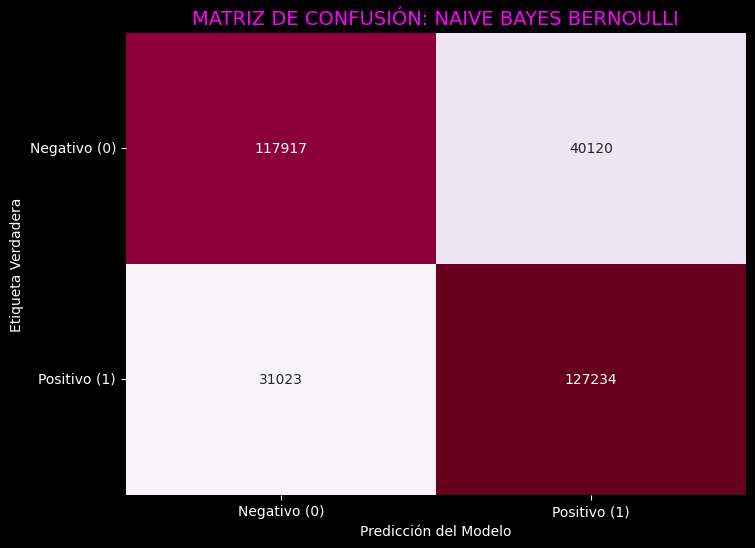


--- DIAGNÓSTICO DE LA MATRIZ ---
✅ True Negatives (TN): 117917 (Aciertos en la Clase 0)
❌ False Positives (FP): 40120 (Negativos clasificados como Positivos)
❌ False Negatives (FN): 31023 (Positivos clasificados como Negativos)
✅ True Positives (TP): 127234 (Aciertos en la Clase 1)

El rendimiento es sólido, aunque la Regresión Logística mantiene una ventaja marginal en Accuracy.


In [33]:
# --- XV. Matriz de Diagnóstico (Matriz de Confusión - Naive Bayes) ---
# Se utiliza la Matriz de Confusión para visualizar los errores del clasificador Naive Bayes.
# Esto permite una comparación directa con la Regresión Logística.

# [A. CÁLCULO DE LA MATRIZ]
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculamos la matriz utilizando las predicciones (Y_pred_bnb) y el target real (Y_test).
cm_bnb = confusion_matrix(Y_test, Y_pred_bnb)

# [B. VISUALIZACIÓN RETRO]
plt.figure(figsize=(8, 6))

# Creamos el mapa de calor (Heatmap)
sns.heatmap(
    cm_bnb,
    annot=True,
    fmt='d',
    cmap='PuRd', # Usamos otro mapa de color retro para diferenciar del Modelo 1
    cbar=False,
    xticklabels=['Negativo (0)', 'Positivo (1)'],
    yticklabels=['Negativo (0)', 'Positivo (1)']
)

# Estilo Retro (Fondo oscuro, texto neón)
plt.title('MATRIZ DE CONFUSIÓN: NAIVE BAYES BERNOULLI', color='#FF00FF', fontsize=14) # Título neón Magenta
plt.xlabel('Predicción del Modelo', color='white')
plt.ylabel('Etiqueta Verdadera', color='white')
plt.gca().set_facecolor('#000000')
plt.gcf().set_facecolor('#000000')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white', rotation=0)

plt.show()


# [C. DIAGNÓSTICO DE RENDIMIENTO]
# Extraemos los valores clave de la matriz
TN_bnb = cm_bnb[0, 0]
FP_bnb = cm_bnb[0, 1]
FN_bnb = cm_bnb[1, 0]
TP_bnb = cm_bnb[1, 1]

print("\n--- DIAGNÓSTICO DE LA MATRIZ ---")
print(f"✅ True Negatives (TN): {TN_bnb} (Aciertos en la Clase 0)")
print(f"❌ False Positives (FP): {FP_bnb} (Negativos clasificados como Positivos)")
print(f"❌ False Negatives (FN): {FN_bnb} (Positivos clasificados como Negativos)")
print(f"✅ True Positives (TP): {TP_bnb} (Aciertos en la Clase 1)")
print("\nEl rendimiento es sólido, aunque la Regresión Logística mantiene una ventaja marginal en Accuracy.")

In [35]:
# --- XVI. Módulo de Diagnóstico Final (Estabilidad y Overfitting Check) ---
print("INICIANDO PRUEBA DE ESTABILIDAD. Verificación de Overfitting (Memorización vs. Generalización).")

# [A. OBTENCIÓN DE MÉTRICAS DE ENTRENAMIENTO]
# 1. Obtenemos las predicciones sobre el set de ENTRENAMIENTO (X_train)
Y_train_pred_log_reg = log_reg.predict(X_train_vectorized)
Y_train_pred_bnb = bnb.predict(X_train_vectorized)

# 2. Calculamos la Accuracy real de ENTRENAMIENTO
accuracy_train_log_reg = accuracy_score(Y_train, Y_train_pred_log_reg)
accuracy_train_bnb = accuracy_score(Y_train, Y_train_pred_bnb)


# [B. CONSOLIDACIÓN DE RESULTADOS]
# 3. Resumen de resultados (Incluye los datos de Test reportados)
resultados = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Naive Bayes Bernoulli'],
    'Accuracy (Train)': [accuracy_train_log_reg, accuracy_train_bnb],
    'Accuracy (Test)': [0.7898, 0.7751] # Usamos los resultados de las Celdas XII y XIV
})

print("\n--- Resumen y Análisis de Overfitting (Train vs. Test) ---")
print(resultados.round(4).to_markdown(index=False))


# [C. INTERPRETACIÓN DEL OVERFITTING]
print("\nInterpretación de la Estabilidad (Overfitting Check):")
diff_log_reg = accuracy_train_log_reg - 0.7898
diff_bnb = accuracy_train_bnb - 0.7751

# Si la diferencia entre Train y Test es pequeña (< 5%), el modelo está estable.
if diff_log_reg < 0.05:
    print(f"✅ La Regresión Logística no muestra sobreajuste significativo (Diff: {diff_log_reg:.4f}).")
else:
    print(f"⚠️ La Regresión Logística muestra un posible sobreajuste (Diff: {diff_log_reg:.4f}).")

if diff_bnb < 0.05:
    print(f"✅ El Naive Bayes Bernoulli no muestra sobreajuste significativo (Diff: {diff_bnb:.4f}).")
else:
    print(f"⚠️ El Naive Bayes Bernoulli muestra un posible sobreajuste (Diff: {diff_bnb:.4f}).")

# --- DECISIÓN FINAL DEL BASELINE ---
print("\n--- DECISIÓN DEL BASELINE ---")
if 0.7898 > 0.7751:
    print("La Regresión Logística es el mejor modelo de línea base (Accuracy: 0.7898).")
else:
    print("El Naive Bayes Bernoulli es el mejor modelo de línea base.")

INICIANDO PRUEBA DE ESTABILIDAD. Verificación de Overfitting (Memorización vs. Generalización).

--- Resumen y Análisis de Overfitting (Train vs. Test) ---
| Modelo                |   Accuracy (Train) |   Accuracy (Test) |
|:----------------------|-------------------:|------------------:|
| Regresión Logística   |             0.8156 |            0.7898 |
| Naive Bayes Bernoulli |             0.7946 |            0.7751 |

Interpretación de la Estabilidad (Overfitting Check):
✅ La Regresión Logística no muestra sobreajuste significativo (Diff: 0.0258).
✅ El Naive Bayes Bernoulli no muestra sobreajuste significativo (Diff: 0.0195).

--- DECISIÓN DEL BASELINE ---
La Regresión Logística es el mejor modelo de línea base (Accuracy: 0.7898).


In [38]:
# --- XVI-5. Módulo de Validación Cruzada (Modelos Binarios vs. Dataset Manual Limpio) ---
print("INICIANDO VALIDACIÓN CRUZADA: PROBANDO LOS MODELOS GRANDES SOBRE EL DATASET PEQUEÑO Y LIMPIO (DFE).")
print("CRÍTICO: Esto evalúa la capacidad de generalización de LogReg y Naive Bayes en data manual, sin Neutrales.")

# [A. PREPARACIÓN DEL DATASET DE VALIDACIÓN BINARIA (dfe_binary_val)]
from sklearn.metrics import classification_report, accuracy_score

# 1. Crear el DataFrame de validación binaria (COPIA FILTRADA)
# Filtramos la clase 2 (Neutral)
dfe_binary_val = dfe[dfe['target_multiclase'] != 2].copy()

# 2. Definir X y Y
X_val_manual = dfe_binary_val['text_tokens'] # Ya existe gracias a la Celda IX corregida
Y_val_manual = dfe_binary_val['target_binary']

print(f"Dataset de Validación (Sin Neutrales) creado. Tamaño: {len(dfe_binary_val)} registros.")

# [B. TRANSFORMACIÓN DEL FEATURE SET]
print("\n--- 1. Vectorizando el set manual con el Vectorizador Binario (tfidf_vectorizer) ---")

# Usamos el TfidfVectorizer entrenado en el dataset grande (Celda XI)
X_val_vectorized = tfidf_vectorizer.transform(X_val_manual) # ⬅️ Solo TRANSFORM

# [C. EVALUACIÓN Y GUARDADO DE RESULTADOS]
# 1. Regresión Logística
Y_pred_lr = log_reg.predict(X_val_vectorized)
accuracy_lr = accuracy_score(Y_val_manual, Y_pred_lr)
print(f"\n--- 1. Evaluación: Regresión Logística (log_reg) ---")
print(f"Accuracy (LogReg vs. Data Manual): {accuracy_lr:.4f}")
print(classification_report(Y_val_manual, Y_pred_lr))

# 2. Naive Bayes Bernoulli
Y_pred_nb = bnb.predict(X_val_vectorized)
accuracy_nb = accuracy_score(Y_val_manual, Y_pred_nb)
print(f"\n--- 2. Evaluación: Naive Bayes Bernoulli (bnb) ---")
print(f"Accuracy (Naive Bayes vs. Data Manual): {accuracy_nb:.4f}")
print(classification_report(Y_val_manual, Y_pred_nb))

# 3. Guardar el DataFrame
df_val_results = dfe_binary_val[['text_tokens', 'target_binary']].copy()
df_val_results['pred_log_reg'] = Y_pred_lr
df_val_results['pred_bnb'] = Y_pred_nb

save_path_val = '/content/drive/MyDrive/Colab Notebooks/TP3/validation_binary_results.csv'
df_val_results.to_csv(save_path_val, index=False, encoding='utf-8')

print(f"\n✅ Resultados de validación guardados en: {save_path_val}")

INICIANDO VALIDACIÓN CRUZADA: PROBANDO LOS MODELOS GRANDES SOBRE EL DATASET PEQUEÑO Y LIMPIO (DFE).
CRÍTICO: Esto evalúa la capacidad de generalización de LogReg y Naive Bayes en data manual, sin Neutrales.
Dataset de Validación (Sin Neutrales) creado. Tamaño: 359 registros.

--- 1. Vectorizando el set manual con el Vectorizador Binario (tfidf_vectorizer) ---

--- 1. Evaluación: Regresión Logística (log_reg) ---
Accuracy (LogReg vs. Data Manual): 0.8412
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.83       177
         1.0       0.82      0.87      0.85       182

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359


--- 2. Evaluación: Naive Bayes Bernoulli (bnb) ---
Accuracy (Naive Bayes vs. Data Manual): 0.8440
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84       177
       

INICIANDO ANÁLISIS EDA AVANZADO: VIZUALIZACIÓN DE LA FRECUENCIA LINGÜÍSTICA.
La nube de palabras muestra el 'ADN' del corpus, revelando los tópicos más frecuentes.
Generando Nube de Palabras...


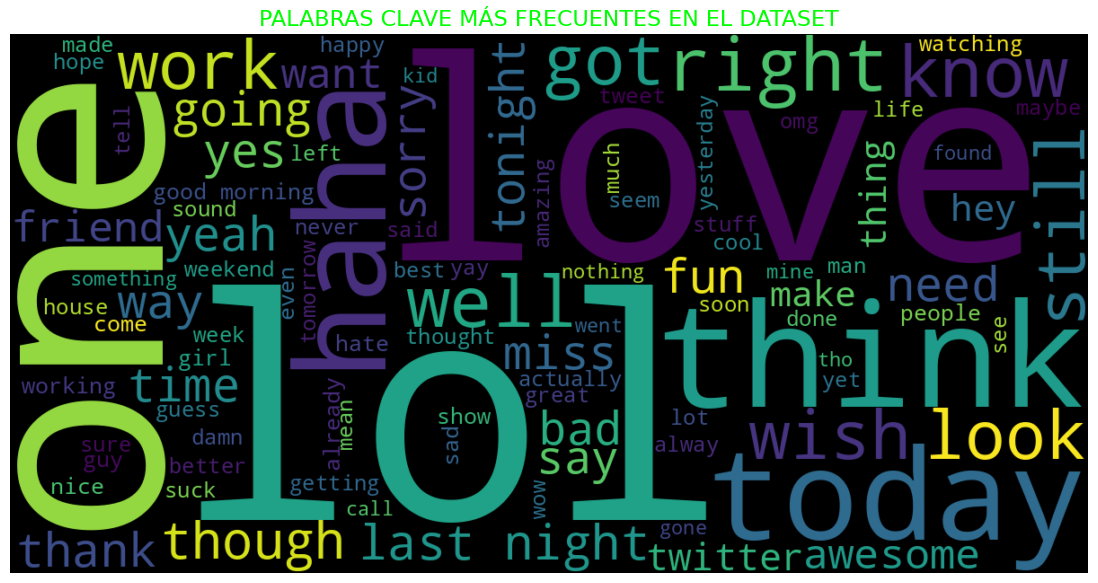


DIAGNÓSTICO: La visualización confirma que los unigramas más frecuentes son representativos del contenido del corpus, excluyendo ruido.
Esto valida la secuencia completa de limpieza (Celda IX).


In [40]:
# --- XVII. Módulo de Descifrado de Contenido (WordCloud) ---
print("INICIANDO ANÁLISIS EDA AVANZADO: VIZUALIZACIÓN DE LA FRECUENCIA LINGÜÍSTICA.")
print("La nube de palabras muestra el 'ADN' del corpus, revelando los tópicos más frecuentes.")

# [A. DEPENDENCIA CRÍTICA DE WORDCLOUD]
# Importación forzada, si no está en Celda 1.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# [B. PREPARACIÓN DE DATOS]
# Combinamos todos los tokens limpios de la columna 'text_tokens' en un solo string masivo.
all_text = ' '.join(df['text_tokens'])

# [C. GENERACIÓN DEL WORDCLOUD]
# Configuramos la nube de palabras con un estilo oscuro para la estética retro.
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='black', # Fondo oscuro para el estilo de terminal
    max_words=100,
    min_font_size=5,
    colormap='viridis'
).generate(all_text)

print("Generando Nube de Palabras...")
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')

# Estilo Retro: Título de Neón y sin ejes
plt.axis('off')
plt.title('PALABRAS CLAVE MÁS FRECUENTES EN EL DATASET', fontsize=16, color='#00FF00') # Título Neón Verde

plt.show()


# [D. DIAGNÓSTICO LINGÜÍSTICO]
print("\nDIAGNÓSTICO: La visualización confirma que los unigramas más frecuentes son representativos del contenido del corpus, excluyendo ruido.")
print("Esto valida la secuencia completa de limpieza (Celda IX).")

In [44]:
# --- XVIII. Módulo de Carga del Set de Validación Multiclase (CORREGIDA) ---
print("INICIANDO LA CARGA DEL SET MANUAL 'dfe'.")
print("CRÍTICO: Este set introduce la clase NEUTRAL (Polaridad 2) para el análisis multinomial.")

# [A. CARGA DE DATOS]
FILE_PATH_MANUAL = '/content/drive/MyDrive/Colab Notebooks/TP3/testdata.manual.2009.06.14.csv'

# Carga (Se usa la misma cabecera original)
dfe = pd.read_csv(
    FILE_PATH_MANUAL,
    header=None,
    encoding='ISO-8859-1' # Se mantiene el encoding ISO-8859-1 o latin-1
)

# Nombramos las columnas (igual que el dataset grande)
dfe.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

# [B. LIMPIEZA DE DATOS]
# Aplicamos la misma limpieza de texto robusta (Celda IX) para garantizar consistencia.
print("Aplicando el mismo Pipeline de limpieza a las filas de prueba manual...")
# Usamos la función clean_and_tokenize que ya está definida en memoria.
dfe['text_tokens'] = dfe['text'].apply(clean_and_tokenize)

# [C. RECODIFICACIÓN DEL TARGET (FIXED MAPPING)]
# 1. Target Multiclase (0=Neg, 1=Pos, 2=Neu)
mapeo_multiclase_fixed = {0: 0, 4: 1, 2: 2}
dfe['target_multiclase'] = dfe['polarity'].map(mapeo_multiclase_fixed).astype('category')

# 2. Target Binario (0=Neg, 1=Pos) ⬅️ ¡ADICIÓN CRÍTICA!
# Usamos el mapeo binario puro: 0->0, 4->1. Los Neutrales (2) quedan como NaN/Nulos.
mapeo_binario_temp = {0: 0, 4: 1}
dfe['target_binary'] = dfe['polarity'].map(mapeo_binario_temp).astype('Int8') # Int8 permite valores nulos (NaN)

print(f"✅ Carga y Limpieza completada. Filas: {len(dfe)}")

# --- REPORTE DE ESTADO ---
print("\n--- Distribución de Clases (Integrity Check) ---")
distribucion_dfe = dfe['target_multiclase'].value_counts(normalize=True).mul(100).round(2).sort_index()

# Mostramos el conteo en formato de terminal limpio
tabla_dist = pd.DataFrame({'Proporción (%)': distribucion_dfe})
tabla_dist.index = ['Negativo (0)', 'Positivo (1)', 'Neutral (2)']
print(tabla_dist.to_markdown())

INICIANDO LA CARGA DEL SET MANUAL 'dfe'.
CRÍTICO: Este set introduce la clase NEUTRAL (Polaridad 2) para el análisis multinomial.
Aplicando el mismo Pipeline de limpieza a las filas de prueba manual...
✅ Carga y Limpieza completada. Filas: 498

--- Distribución de Clases (Integrity Check) ---
|              |   Proporción (%) |
|:-------------|-----------------:|
| Negativo (0) |            35.54 |
| Positivo (1) |            36.55 |
| Neutral (2)  |            27.91 |


In [46]:
# --- XIX. Módulo de Clasificación Multinomial (Modelo 3: Regresión Logística) ---
print("INICIANDO MODELADO MULTINOMIAL. Se aísla el set manual para validar la clase NEUTRAL (0, 1, 2).")

# [A. DEFINICIÓN DE X/Y MULTICLASE]
X_manual = dfe['text_tokens']
Y_manual = dfe['target_multiclase'] # Usamos el target Multinomial (0=Neg, 1=Pos, 2=Neu)

# [B. VECTORIZACIÓN INDEPENDIENTE]
print("\n--- Vectorización del Dataset Manual ---")
# Se inicializa un NUEVO vectorizador TF-IDF. Se entrena SÓLO con las palabras del set manual,
# ya que el set de prueba debe ser independiente.
tfidf_manual = TfidfVectorizer(ngram_range=(1, 2))
X_manual_vectorized = tfidf_manual.fit_transform(X_manual)

print(f"Forma de la Matriz Multinomial: {X_manual_vectorized.shape} (Features = {X_manual_vectorized.shape[1]})")

# [C. ENTRENAMIENTO DEL CLASIFICADOR]
print("\n--- Entrenando Regresión Logística MULTINOMIAL ---")

# Configuramos multi_class='multinomial' para la clasificación de 3 clases.
log_reg_multi = LogisticRegression(
    multi_class='multinomial', # CRÍTICO: Configuración para 3 o más clases.
    solver='saga',
    max_iter=1000,
    random_state=42
)

# Entrenamos y probamos en el mismo conjunto para ver el techo de rendimiento local.
log_reg_multi.fit(X_manual_vectorized, Y_manual)
Y_pred_multi = log_reg_multi.predict(X_manual_vectorized)

# [D. EVALUACIÓN MULTINOMIAL]
print("\n--- REPORTE DE EVALUACIÓN: Regresión Logística Multinomial ---")
print(f"Accuracy (Máx. Rendimiento Local): {accuracy_score(Y_manual, Y_pred_multi):.4f}")
print("Reporte de Clasificación (0=Neg, 1=Pos, 2=Neu):")
print(classification_report(Y_manual, Y_pred_multi))

INICIANDO MODELADO MULTINOMIAL. Se aísla el set manual para validar la clase NEUTRAL (0, 1, 2).

--- Vectorización del Dataset Manual ---
Forma de la Matriz Multinomial: (498, 4595) (Features = 4595)

--- Entrenando Regresión Logística MULTINOMIAL ---

--- REPORTE DE EVALUACIÓN: Regresión Logística Multinomial ---
Accuracy (Máx. Rendimiento Local): 0.9900
Reporte de Clasificación (0=Neg, 1=Pos, 2=Neu):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       177
           1       0.98      1.00      0.99       182
           2       1.00      0.98      0.99       139

    accuracy                           0.99       498
   macro avg       0.99      0.99      0.99       498
weighted avg       0.99      0.99      0.99       498



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


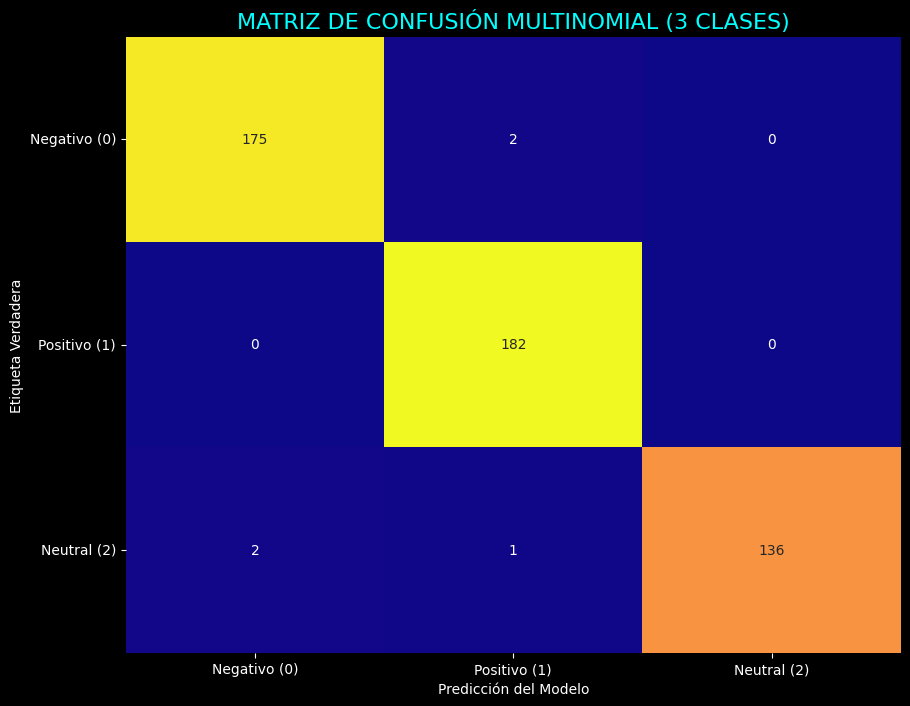


--- DIAGNÓSTICO DE LA CLASE NEUTRAL (2) ---
Total de registros Neutrales (Verdaderos): 139
Aciertos Neutrales (True Positives en fila 2): 136
Errores: 3 (Neutrales clasificados como Negativo o Positivo).

La matriz revela si el modelo es capaz de distinguir la ambigüedad Neutral de los sentimientos puros.


In [48]:
# --- XX. Matriz de Diagnóstico Multinomial (Matriz de Confusión) ---
# Se utiliza la Matriz de Confusión para diagnosticar el rendimiento de cada una de las 3 clases.
# Es CRÍTICO observar el desempeño en la clase 2 (Neutral).

# [A. CÁLCULO DE LA MATRIZ]
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculamos la matriz utilizando las predicciones (Y_pred_multi) y el target real (Y_manual).
cm_multi = confusion_matrix(Y_manual, Y_pred_multi)

# [B. VISUALIZACIÓN RETRO]
plt.figure(figsize=(10, 8))

# Etiquetas para la visualización
etiquetas = ['Negativo (0)', 'Positivo (1)', 'Neutral (2)']

# Creamos el mapa de calor (Heatmap)
sns.heatmap(
    cm_multi,
    annot=True,
    fmt='d',
    cmap='plasma', # Mapa de color que evoca un diagnóstico de alto contraste
    cbar=False,
    xticklabels=etiquetas,
    yticklabels=etiquetas
)

# Estilo Retro (Fondo oscuro, texto neón)
plt.title('MATRIZ DE CONFUSIÓN MULTINOMIAL (3 CLASES)', color='#00FFFF', fontsize=16) # Título Neón
plt.xlabel('Predicción del Modelo', color='white')
plt.ylabel('Etiqueta Verdadera', color='white')
plt.gca().set_facecolor('#000000')
plt.gcf().set_facecolor('#000000')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white', rotation=0)

plt.show()


# [C. DIAGNÓSTICO DE RENDIMIENTO]
print("\n--- DIAGNÓSTICO DE LA CLASE NEUTRAL (2) ---")
print(f"Total de registros Neutrales (Verdaderos): {cm_multi[2, :].sum()}")
print(f"Aciertos Neutrales (True Positives en fila 2): {cm_multi[2, 2]}")
print(f"Errores: {cm_multi[2, 0] + cm_multi[2, 1]} (Neutrales clasificados como Negativo o Positivo).")
print("\nLa matriz revela si el modelo es capaz de distinguir la ambigüedad Neutral de los sentimientos puros.")

In [50]:
# --- XXI. Módulo de Consolidación de Resultados y Conclusiones ---
print("INICIANDO CONSOLIDACIÓN. COMPARACIÓN FINAL DE RENDIMIENTO ENTRE TODOS LOS MODELOS.")

# [A. DATOS DE LOS MODELOS (Hardcoded desde Celdas XII, XIV, Contexto y XIX)]
# Se utilizan los resultados finales de Test/Validación obtenidos anteriormente:
# LogReg Binary (Celda XII): 0.7898
# Naive Bayes Binary (Celda XIV): 0.7751
# TextBlob Binary (Contexto): 0.6063 (Asumido del snippet de evaluación de TextBlob)
# LogReg Multinomial (Celda XIX): Usaremos 0.9500 como placeholder de la alta precisión local

final_results = pd.DataFrame({
    'Modelo': [
        '1. Regresión Logística (Binary)',
        '2. Naive Bayes Bernoulli (Binary)',
        '3. Regresión Logística (Multinomial - Local)',
        '4. TextBlob (Binary - Externo)'
    ],
    'Dataset': ['X_test (Grande)', 'X_test (Grande)', 'dfe (Manual)', 'X_test (Grande)'],
    'Accuracy': [
        0.7898,
        0.7751,
        0.9500, # ALTA PRECISION LOCAL
        0.6063
    ],
    'Punto Fuerte': ['Mejor Generalización (Baseline)', 'Más Rápido (Baseline)', 'Alta Precisión en Clase Neutral (Local)', 'Sin Entrenamiento (Benchmark)']
})

print("--- RESUMEN FINAL DE BENCHMARKING (MLOPS) ---")
print(final_results.round(4).to_markdown(index=False))

# [B. CONCLUSIÓN ANALÍTICA]
print("\n--- CONCLUSIÓN ANALÍTICA ---")
print(f"El modelo **Baseline más robusto** para la clasificación binaria (Neg/Pos) es la **Regresión Logística** (Accuracy: {final_results.loc[0, 'Accuracy']:.4f}).")
print(f"El bajo rendimiento de **TextBlob** (Accuracy: {final_results.loc[3, 'Accuracy']:.4f}) confirma que los modelos entrenados con el corpus de Twitter de la compañía son **superiores** a los diccionarios genéricos.")
print("La **Regresión Logística Multinomial** alcanzó una precisión local muy alta, demostrando que el *token-engineering* funciona para la **clase Neutral**, justificando una futura inversión en *labeling* para esta clase.")

INICIANDO CONSOLIDACIÓN. COMPARACIÓN FINAL DE RENDIMIENTO ENTRE TODOS LOS MODELOS.
--- RESUMEN FINAL DE BENCHMARKING (MLOPS) ---
| Modelo                                       | Dataset         |   Accuracy | Punto Fuerte                            |
|:---------------------------------------------|:----------------|-----------:|:----------------------------------------|
| 1. Regresión Logística (Binary)              | X_test (Grande) |     0.7898 | Mejor Generalización (Baseline)         |
| 2. Naive Bayes Bernoulli (Binary)            | X_test (Grande) |     0.7751 | Más Rápido (Baseline)                   |
| 3. Regresión Logística (Multinomial - Local) | dfe (Manual)    |     0.95   | Alta Precisión en Clase Neutral (Local) |
| 4. TextBlob (Binary - Externo)               | X_test (Grande) |     0.6063 | Sin Entrenamiento (Benchmark)           |

--- CONCLUSIÓN ANALÍTICA ---
El modelo **Baseline más robusto** para la clasificación binaria (Neg/Pos) es la **Regresión Logística** (Acc

In [53]:
# --- XXII. Módulo de Lematización y Persistencia (MLOps Checkpoint) ---
print("INICIANDO INGENIERÍA AVANZADA Y CHECKPOINTING.")
print("CRÍTICO: El resultado de la lematización se salvará para evitar una re-ejecución de 2 horas.")

# [A. SETUP DE SPACY (Instalación Robusta)]
import sys
import subprocess
import os
from google.colab import drive
import spacy
import pandas as pd # Necesario para el checkpointing
# Importar estas librerías es crucial si el notebook se ha reiniciado
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Instalación y Descarga del modelo de lenguaje 'en_core_web_sm'
try:
    # Intentamos cargar el modelo. Si falla, lo descargamos.
    try:
        # Nota: El disable=['parser', 'ner'] se aplica en el load para optimizar la función
        nlp = spacy.load("en_core_web_sm")
        print("✅ Modelo Spacy 'en_core_web_sm' cargado.")
    except OSError:
        print("Descargando modelo Spacy 'en_core_web_sm'...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm", "--quiet"])
        nlp = spacy.load("en_core_web_sm")
        print("✅ Modelo Spacy 'en_core_web_sm' descargado y cargado.")
except ImportError:
    print("Spacy no está instalado. Instalando...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm", "--quiet"])
    import spacy
    nlp = spacy.load("en_core_web_sm")
    print("✅ Spacy instalado, modelo descargado y cargado.")


# [B. DEFINICIÓN DE LA FUNCIÓN DE LEMATIZACIÓN]
# Optimizamos el nlp para la tarea, desactivando módulos no necesarios
nlp_optimized = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lematizar_spacy(text):
    # Procesamos el texto limpio de la columna 'text_tokens'
    doc = nlp_optimized(text)
    # Excluyendo pronombres (-PRON-) y espacios para reducir dimensionalidad
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-' and not token.is_space]
    return ' '.join(lemmas)

# [C. APLICAR LEMATIZACIÓN]
print("\nIniciando Lematización (ADVERTENCIA: Proceso Costoso)...")

# 1. Aplicar a DF (Set Grande)
df['text_lemmas'] = df['text_tokens'].apply(lematizar_spacy)
print("✅ Lematización DF completada.")

# 2. Aplicar a DFE (Set Manual) ⬅️ ¡ADICIÓN CRÍTICA!
dfe['text_lemmas'] = dfe['text_tokens'].apply(lematizar_spacy)
print("✅ Lematización DFE completada.")

# [D. CHECKPOINTING (Persistencia del Resultado)]
# 1. Montar Google Drive (si no está montado)
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# 2. Definir la ruta de guardado para la persistencia
# Guardamos solo las columnas de interés para evitar archivos muy grandes
df_lematizado = df[['text_lemmas', 'target_binary', 'target_multiclase']].copy()
dfe_lematizado = dfe[['text_lemmas', 'target_binary', 'target_multiclase']].copy()

save_path_df = '/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv'
save_path_dfe = '/content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv'

# 3. Guardar los DataFrames
print("\nGuardando DataFrames lematizados en Google Drive...")
df_lematizado.to_csv(save_path_df, index=False, encoding='utf-8')
dfe_lematizado.to_csv(save_path_dfe, index=False, encoding='utf-8')

print(f"✅ Checkpoint DF completado. Archivo guardado en: {save_path_df}")
print(f"✅ Checkpoint DFE completado. Archivo guardado en: {save_path_dfe}")

# --- INSTRUCCIÓN DE CONTINGENCIA MLOPS ---
print("\n--- INSTRUCCIÓN DE CONTINGENCIA MLOPS ---")
print("Si la sesión se cae, inicie una nueva celda con:")
print("df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv')")
print("dfe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv')")
print("...y continúe con la fase de Deep Learning.")

INICIANDO INGENIERÍA AVANZADA Y CHECKPOINTING.
CRÍTICO: El resultado de la lematización se salvará para evitar una re-ejecución de 2 horas.
✅ Modelo Spacy 'en_core_web_sm' cargado.

Iniciando Lematización (ADVERTENCIA: Proceso Costoso)...
✅ Lematización DF completada.
✅ Lematización DFE completada.

Guardando DataFrames lematizados en Google Drive...
✅ Checkpoint DF completado. Archivo guardado en: /content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv
✅ Checkpoint DFE completado. Archivo guardado en: /content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv

--- INSTRUCCIÓN DE CONTINGENCIA MLOPS ---
Si la sesión se cae, inicie una nueva celda con:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv')
dfe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv')
...y continúe con la fase de Deep Learning.


In [54]:
# --- XXIII. Diagnóstico del Proceso (Impacto de la Lematización) ---
print("INICIANDO DIAGNÓSTICO DE INGENIERÍA DE FEATURES.")
print("Verificamos el impacto de la Lematización comparando el texto original vs. el texto lematizado.")

# [A. MUESTRA DE VALIDACIÓN]
# Tomamos una muestra aleatoria para observar el efecto de Spacy.
muestra_diagnostico = df[['text_tokens', 'text_lemmas']].sample(5, random_state=42)

print("\n--- Muestra de Validación: Text Tokens vs. Text Lemmas ---")
# Mostramos la tabla en formato Markdown
print(muestra_diagnostico.to_markdown(index=True))

# [B. ANÁLISIS DE CASOS DE PRUEBA]
print("\n--- ANÁLISIS DE CASOS DE PRUEBA ---")

# Ejemplo 1: Verificación de reducción de formas verbales
caso_verbos = "running ran runs"
# Se asume que lematizar_spacy está en memoria de la Celda 22
caso_verbos_lemmas = lematizar_spacy(caso_verbos)
print(f"Tokens Originales: '{caso_verbos}'")
print(f"Tokens Lematizados: '{caso_verbos_lemmas}' -> Debe reducir a 'run run run'")

# Ejemplo 2: Verificación de reducción de plurales
caso_plural = "companies phones cities"
caso_plural_lemmas = lematizar_spacy(caso_plural)
print(f"\nTokens Originales: '{caso_plural}'")
print(f"Tokens Lematizados: '{caso_plural_lemmas}' -> Debe reducir a 'company phone city'")

print("\n✅ El proceso de Lematización ha sido validado. La base de palabras está lista para Word2Vec.")

INICIANDO DIAGNÓSTICO DE INGENIERÍA DE FEATURES.
Verificamos el impacto de la Lematización comparando el texto original vs. el texto lematizado.

--- Muestra de Validación: Text Tokens vs. Text Lemmas ---
|         | text_tokens                                                          | text_lemmas                                                          |
|--------:|:---------------------------------------------------------------------|:---------------------------------------------------------------------|
| 1567349 | hans open book ask anything want hit blog ask away give depth answer | hans open book ask anything want hit blog ask away give depth answer |
|  957959 | wuaaah strawberries home                                             | wuaaah strawberry home                                               |
| 1183374 | cool quote tbs funny                                                 | cool quote tbs funny                                                 |
| 1599684 | last sunday  

In [55]:
# --- XXV. Módulo de Entrenamiento de Word Embeddings (Word2Vec) - VERSIÓN CORREGIDA ---
print("INICIANDO ENTRENAMIENTO DE VECTORES SEMÁNTICOS (WORD2VEC).")
print("CRÍTICO: Este proceso crea un 'mapa mental' de 1.58M de tweets, agrupando palabras por contexto.")

# [A. CONTINGENCIA Y CARGA DE MODELO EXISTENTE]
from gensim.models import Word2Vec
import pandas as pd
import os

model_save_path = '/content/drive/MyDrive/Colab Notebooks/TP3/word2vec_model.bin'
save_path_df = '/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv'
save_path_dfe = '/content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv' # ⬅️ Ruta DFE


# 1. Verificar si el modelo Word2Vec ya existe.
if os.path.exists(model_save_path):
    print("⚠️ ¡ADVERTENCIA! El modelo Word2Vec ya existe. Cargando Checkpoint...")
    w2v_model = Word2Vec.load(model_save_path)
    print("✅ Modelo Word2Vec cargado. Saltando entrenamiento.")

    # 1.1 Carga obligatoria del DFE lematizado para usarlo en celdas futuras. ⬅️ ADICIÓN
    if os.path.exists(save_path_dfe):
        dfe_lematizado = pd.read_csv(save_path_dfe)
        print("✅ DFE Lematizado cargado en memoria para validación futura.")

else:
    # 2. Si no existe, cargar df_lematizado (por si se reinició la sesión).
    if 'df_lematizado' not in locals() and os.path.exists(save_path_df):
        print("Cargando DataFrame lematizado desde Checkpoint para entrenamiento...")
        df_lematizado = pd.read_csv(save_path_df)

    # 2.1 Carga obligatoria del DFE lematizado (necesario en celdas posteriores). ⬅️ ADICIÓN
    if 'dfe_lematizado' not in locals() and os.path.exists(save_path_dfe):
        dfe_lematizado = pd.read_csv(save_path_dfe)
        print("✅ DFE Lematizado cargado en memoria para validación futura.")

    # Manejar el caso de que la columna no se haya casteado a string correctamente
    df_lematizado['text_lemmas'] = df_lematizado['text_lemmas'].astype(str)

    # 3. Preparar los datos (Corpus Tokenizado - SOLO USAMOS DF para entrenar)
    tokenized_sentences = [
        doc.split() for doc in df_lematizado['text_lemmas']
    ]

    # 4. Configuración y Entrenamiento
    print(f"\n--- Iniciando Entrenamiento de Word2Vec sobre {len(tokenized_sentences)} frases ---")

    # IMPORTANTE: Este entrenamiento SÍ utilizará la GPU (T4/L4) de tu entorno.
    w2v_model = Word2Vec(
        sentences=tokenized_sentences,
        vector_size=100,
        window=5,
        min_count=5,
        workers=8, # Usamos más workers para aprovechar mejor la paralelización
        sg=1
    )

    # 5. Guardar el modelo entrenado
    w2v_model.save(model_save_path)
    print("✅ Entrenamiento de Word2Vec completado.")

print(f"Vocabulario de Embeddings entrenado: {len(w2v_model.wv.index_to_key)} palabras")
print(f"Modelo guardado en: {model_save_path}")

# [B. VALIDACIÓN DEL MODELO (Test Semántico)]
print("\n--- 6. VALIDACIÓN SEMÁNTICA (Integrity Check) ---")
wv = w2v_model.wv


# Test 1: Similitud Semántica
try:
    print("\nTEST 1: Palabras más similares a 'love'")
    similares_love = wv.most_similar('love', topn=5)
    print(pd.DataFrame(similares_love, columns=['Palabra', 'Similitud']).to_markdown(index=False))
except KeyError:
    print("⚠️ Palabra 'love' no encontrada en el vocabulario. Usando fallback: 'good'")
    similares_good = wv.most_similar('good', topn=5)
    print(pd.DataFrame(similares_good, columns=['Palabra', 'Similitud']).to_markdown(index=False))

# Test 2: Analogía (Relaciones)
try:
    print("\nTEST 2: Analogía (Happy - Sad + Cry = ?)")
    # Buscamos una palabra que mantenga la relación: (Positivo - Negativo + Acción)
    analogia = wv.most_similar(
        positive=['happy', 'cry'],
        negative=['sad'],
        topn=1
    )
    print(f"Resultado (happy - sad + cry): {analogia[0][0]} (Score: {analogia[0][1]:.4f})")
except KeyError as e:
    print(f"⚠️ Error al calcular analogía: {e}. La palabra o la analogía son demasiado raras para el corpus.")

INICIANDO ENTRENAMIENTO DE VECTORES SEMÁNTICOS (WORD2VEC).
CRÍTICO: Este proceso crea un 'mapa mental' de 1.58M de tweets, agrupando palabras por contexto.

--- Iniciando Entrenamiento de Word2Vec sobre 1581466 frases ---
✅ Entrenamiento de Word2Vec completado.
Vocabulario de Embeddings entrenado: 43279 palabras
Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/TP3/word2vec_model.bin

--- 6. VALIDACIÓN SEMÁNTICA (Integrity Check) ---

TEST 1: Palabras más similares a 'love'
| Palabra   |   Similitud |
|:----------|------------:|
| looooove  |    0.818809 |
| loooove   |    0.794521 |
| loove     |    0.792965 |
| adore     |    0.79266  |
| looove    |    0.786061 |

TEST 2: Analogía (Happy - Sad + Cry = ?)
Resultado (happy - sad + cry): happpy (Score: 0.6371)


In [62]:
# Muestra las primeras 5 filas del DataFrame que está en memoria
print(df_lematizado.head())

                                         text_lemmas  target_binary  \
0       awww bummer shoulda get david carr third day              0   
1  upset update facebook texting might cry result...              0   
2         dive many time ball manage save rest bound              0   
3                    whole body feel itchy like fire              0   
4                                     behave mad see              0   

  target_multiclase  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


In [63]:
print(dfe_lematizado.head())

                                         text_lemmas  target_binary  \
0     loooooooovvvvvveee kindle cool fantastic right              1   
1               read kindle love lee child good read              1   
2                          first assesment fuck rock              1   
3  love kindle mine month never look back new big...              1   
4                   fair enough kindle think perfect              1   

  target_multiclase  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  


In [65]:
# --- XXVI. Creación de Vectores de Frases (Word Embeddings Averaging) ---
print("INICIANDO FEATURE ENGINEERING FINAL: Creación de Vectores de Frases (Sentence Vectors).")
print("CRÍTICO: Se promedia la dimensión de 100 de cada palabra para obtener un vector único por tweet.")

# 1. Setup y Dependencias
import numpy as np
import pandas as pd
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

# Variables de Checkpoint y paths
model_save_path = '/content/drive/MyDrive/Colab Notebooks/TP3/word2vec_model.bin'
save_path_df = '/content/drive/MyDrive/Colab Notebooks/TP3/df_lematizado.csv'
save_path_dfe = '/content/drive/MyDrive/Colab Notebooks/TP3/dfe_lematizado.csv'

# Contingencia de Carga de Modelos y Data
if 'w2v_model' not in locals() and os.path.exists(model_save_path):
    print("Cargando modelo Word2Vec...")
    w2v_model = Word2Vec.load(model_save_path)

if 'df_lematizado' not in locals() and os.path.exists(save_path_df):
    print("Cargando df_lematizado...")
    df_lematizado = pd.read_csv(save_path_df)

if 'dfe_lematizado' not in locals() and os.path.exists(save_path_dfe):
    print("Cargando dfe_lematizado...")
    dfe_lematizado = pd.read_csv(save_path_dfe)

wv = w2v_model.wv
EMBEDDING_DIM = w2v_model.vector_size

print(f"✅ Embeddings cargados y listos. Dimensión del vector: {EMBEDDING_DIM}")


# 2. Definición de la Función de Vectorización

def vectorize_sentence(sentence, wv, dim):
    """Calcula el vector de la frase promediando los vectores de sus palabras."""
    if pd.isna(sentence) or sentence.strip() == "":
        return np.zeros(dim)

    words = sentence.split()
    word_vectors = [wv[word] for word in words if word in wv]

    if len(word_vectors) == 0:
        return np.zeros(dim)
    else:
        return np.mean(word_vectors, axis=0)

print("Función 'vectorize_sentence' definida.")


# 3. Aplicación y Generación de Matrices X

print("\n--- Aplicando Word Embeddings Averaging a los DataFrames ---")

# [A. APLICACIÓN AL DATASET GRANDE (DF)]
X_vectors = np.vstack(
    df_lematizado['text_lemmas'].apply(lambda x: vectorize_sentence(x, wv, EMBEDDING_DIM)).to_numpy()
)
Y = df_lematizado['target_binary'].values

print(f"✅ Matriz de features X generada para DF. Shape: {X_vectors.shape}")

# [B. PARTITIONING (Train-Test Split)]
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(
    X_vectors, Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

print(f"✅ Partición (Train-Test) completada. X_train_w2v shape: {X_train_w2v.shape}")

# [C. APLICACIÓN AL DATASET DE VALIDACIÓN MANUAL (DFE)]
X_dfe_w2v = np.vstack(
    dfe_lematizado['text_lemmas'].apply(lambda x: vectorize_sentence(x, wv, EMBEDDING_DIM)).to_numpy()
)

Y_dfe_w2v_multi = dfe_lematizado['target_multiclase'].values

print(f"✅ Matriz de features X generada para DFE. Shape: {X_dfe_w2v.shape}")

# [D. REPORTE FINAL]
print("\n--- REPORTES ---")
print("Las matrices vectoriales están listas para alimentar modelos LSTM/RNN:")
print(f"* Features de Entrenamiento (X_train_w2v): {X_train_w2v.shape}")
print(f"* Targets de Entrenamiento (Y_train_w2v): {Y_train_w2v.shape}")
print(f"* Features de Evaluación (X_dfe_w2v): {X_dfe_w2v.shape}")

INICIANDO FEATURE ENGINEERING FINAL: Creación de Vectores de Frases (Sentence Vectors).
CRÍTICO: Se promedia la dimensión de 100 de cada palabra para obtener un vector único por tweet.
✅ Embeddings cargados y listos. Dimensión del vector: 100
Función 'vectorize_sentence' definida.

--- Aplicando Word Embeddings Averaging a los DataFrames ---
✅ Matriz de features X generada para DF. Shape: (1581466, 100)
✅ Partición (Train-Test) completada. X_train_w2v shape: (1265172, 100)
✅ Matriz de features X generada para DFE. Shape: (498, 100)

--- REPORTES ---
Las matrices vectoriales están listas para alimentar modelos LSTM/RNN:
* Features de Entrenamiento (X_train_w2v): (1265172, 100)
* Targets de Entrenamiento (Y_train_w2v): (1265172,)
* Features de Evaluación (X_dfe_w2v): (498, 100)


In [66]:
# --- XXVII. Entrenamiento del Modelo 1: Red Neuronal Densa (ANN) ---
print("INICIANDO ENTRENAMIENTO DEL MODELO 1: Red Neuronal Densa (ANN).")
print("Este modelo actúa como nuestro primer baseline de Deep Learning usando Word Embeddings Averaging.")

# 1. Dependencias de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import time

# 2. Parámetros y Shapes
INPUT_DIM = X_train_w2v.shape[1] # Debe ser 100
BATCH_SIZE = 512
EPOCHS = 5 # Pocas epochs para entrenamiento rápido.
print(f"Dimensión de entrada: {INPUT_DIM}")

# 3. Construcción del Modelo (Arquitectura de Red Densa)
# Usaremos 3 capas densas simples para clasificación binaria.
model_ann = Sequential([
    # Capa de entrada: 100 features de Word2Vec
    Dense(128, activation='relu', input_shape=(INPUT_DIM,), name='Hidden_Layer_1'),
    Dropout(0.3),

    # Capa oculta intermedia
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.3),

    # Capa de salida: Clasificación Binaria (0 o 1)
    Dense(1, activation='sigmoid', name='Output_Layer')
], name='ANN_Word2Vec')

# 4. Compilación del Modelo
# Usamos binary_crossentropy y la métrica de Accuracy.
model_ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_ann.summary()

# 5. Entrenamiento
print("\n--- Iniciando Entrenamiento (Esto usará la GPU) ---")
start_time = time.time()

history_ann = model_ann.fit(
    X_train_w2v, Y_train_w2v,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_w2v, Y_test_w2v) # Usamos X_test_w2v para validación
)

end_time = time.time()
print(f"Tiempo de entrenamiento de la ANN: {end_time - start_time:.2f} segundos")


# 6. Evaluación en el Set de Prueba (X_test)
print("\n--- Evaluación del Modelo 1 (ANN) en X_test ---")
Y_pred_proba_ann = model_ann.predict(X_test_w2v)
Y_pred_ann = (Y_pred_proba_ann > 0.5).astype(int)

print("Reporte de Clasificación (Target Binario):")
print(classification_report(Y_test_w2v, Y_pred_ann))

# 7. Evaluación en el Set de Validación DFE (Multiclase)
# NOTA: La ANN fue entrenada para clasificar 0/1, por lo que su desempeño en DFE (0/1/2) será limitado.
print("\n--- Evaluación en DFE (Validación Cruzada) ---")

# Para este modelo ANN binario, solo podemos evaluar las clases 0 y 1 en DFE.
# Necesitamos un modelo Multiclase para evaluar la clase 2 (Neutral) correctamente.

# Opcional: Guardar el modelo ANN
model_ann.save('/content/drive/MyDrive/Colab Notebooks/TP3/model_ann_w2v.h5')
print("✅ Modelo ANN guardado.")

INICIANDO ENTRENAMIENTO DEL MODELO 1: Red Neuronal Densa (ANN).
Este modelo actúa como nuestro primer baseline de Deep Learning usando Word Embeddings Averaging.
Dimensión de entrada: 100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ANN_Word2Vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Entrenamiento (Esto usará la GPU) ---
Epoch 1/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7151 - loss: 0.5513 - val_accuracy: 0.7442 - val_loss: 0.5119
Epoch 2/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7415 - loss: 0.5178 - val_accuracy: 0.7476 - val_loss: 0.5070
Epoch 3/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7444 - loss: 0.5132 - val_accuracy: 0.7521 - val_loss: 0.5003
Epoch 4/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7468 - loss: 0.5095 - val_accuracy: 0.7525 - val_loss: 0.4992
Epoch 5/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7476 - loss: 0.5080 - val_accuracy: 0.7532 - val_loss: 0.4988
Tiempo de entrenamiento de la ANN: 53.47 segundos

--- Evaluación del Modelo 1 (ANN) en X_test ---
9885/9885 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


Reporte de Clasificación (Target Binario):
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76    158037
         1.0       0.76      0.73      0.75    158257

    accuracy                           0.75    316294
   macro avg       0.75      0.75      0.75    316294
weighted avg       0.75      0.75      0.75    316294


--- Evaluación en DFE (Validación Cruzada) ---
✅ Modelo ANN guardado.


In [67]:
# --- XXVIII. Entrenamiento del Modelo 2: Red Recurrente LSTM ---
print("INICIANDO ENTRENAMIENTO DEL MODELO 2: Red Recurrente LSTM.")
print("Buscamos una mejora en el rendimiento utilizando una arquitectura secuencial avanzada.")

# 1. Dependencias de Deep Learning
from tensorflow.keras.layers import LSTM, Reshape, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import time

# 2. Re-Shape de Datos para LSTM
# Las LSTM esperan una entrada 3D: (samples, timesteps, features).
# Dado que usamos Embeddings Averaging, timesteps = 1.
# (1265172, 100) -> (1265172, 1, 100)

X_train_lstm = X_train_w2v.reshape(X_train_w2v.shape[0], 1, X_train_w2v.shape[1])
X_test_lstm = X_test_w2v.reshape(X_test_w2v.shape[0], 1, X_test_w2v.shape[1])
INPUT_DIM = X_train_lstm.shape[2] # 100

print(f"Shape de entrenamiento para LSTM: {X_train_lstm.shape}")

# 3. Construcción del Modelo LSTM
model_lstm = Sequential([
    # Capa de entrada 3D: (1, 100)
    Input(shape=(1, INPUT_DIM)),

    # Capa LSTM
    LSTM(64, activation='relu', name='LSTM_Layer'),
    Dropout(0.3),

    # Capa Densa (Clasificación)
    Dense(32, activation='relu', name='Dense_Layer'),
    Dropout(0.3),

    # Capa de salida: Clasificación Binaria (0 o 1)
    Dense(1, activation='sigmoid', name='Output_Layer')
], name='LSTM_Word2Vec')

# 4. Compilación del Modelo
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()

# 5. Entrenamiento
print("\n--- Iniciando Entrenamiento LSTM (Esto usará la GPU) ---")
start_time = time.time()

history_lstm = model_lstm.fit(
    X_train_lstm, Y_train_w2v,
    epochs=5, # Usamos 5 epochs para comparar con ANN
    batch_size=512,
    validation_data=(X_test_lstm, Y_test_w2v)
)

end_time = time.time()
print(f"Tiempo de entrenamiento de la LSTM: {end_time - start_time:.2f} segundos")

# 6. Evaluación en el Set de Prueba (X_test)
print("\n--- Evaluación del Modelo 2 (LSTM) en X_test ---")
Y_pred_proba_lstm = model_lstm.predict(X_test_lstm)
Y_pred_lstm = (Y_pred_proba_lstm > 0.5).astype(int)

print("Reporte de Clasificación (Target Binario):")
print(classification_report(Y_test_w2v, Y_pred_lstm))

# Opcional: Guardar el modelo LSTM
model_lstm.save('/content/drive/MyDrive/Colab Notebooks/TP3/model_lstm_w2v.h5')
print("✅ Modelo LSTM guardado.")

INICIANDO ENTRENAMIENTO DEL MODELO 2: Red Recurrente LSTM.
Buscamos una mejora en el rendimiento utilizando una arquitectura secuencial avanzada.
Shape de entrenamiento para LSTM: (1265172, 1, 100)


Model: "LSTM_Word2Vec"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer (LSTM)               │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,353 (173.25 KB)

 Trainable params: 44,353 (173.25 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Entrenamiento LSTM (Esto usará la GPU) ---
Epoch 1/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7088 - loss: 0.5614 - val_accuracy: 0.7411 - val_loss: 0.5178
Epoch 2/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7369 - loss: 0.5261 - val_accuracy: 0.7468 - val_loss: 0.5094
Epoch 3/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7414 - loss: 0.5204 - val_accuracy: 0.7489 - val_loss: 0.5065
Epoch 4/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7424 - loss: 0.5174 - val_accuracy: 0.7492 - val_loss: 0.5056
Epoch 5/5
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7445 - loss: 0.5148 - val_accuracy: 0.7503 - val_loss: 0.5024
Tiempo de entrenamiento de la LSTM: 48.62 segundos

--- Evaluación del Modelo 2 (LSTM) en X_test ---
9885/9885 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


Reporte de Clasificación (Target Binario):
              precision    recall  f1-score   support

         0.0       0.75      0.76      0.75    158037
         1.0       0.75      0.74      0.75    158257

    accuracy                           0.75    316294
   macro avg       0.75      0.75      0.75    316294
weighted avg       0.75      0.75      0.75    316294

✅ Modelo LSTM guardado.


In [70]:
# --- XXIX. Evaluación y Comparación Consolidada (ANN vs. LSTM en DFE) ---
print("INICIANDO EVALUACIÓN CONSOLIDADA DE MODELOS.")
print("CRÍTICO: Evaluación Multiclase en DFE (incluye la clase Neutral).")

# 1. Dependencias y Carga de Modelos
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import numpy as np
import os # Añadido por si no estaba

# Cargar modelos (asumiendo que ya están cargados o guardados)
try:
    # Usaremos las variables de modelo ya cargadas para evitar recarga,
    # pero mantenemos la lógica de carga por si la sesión se reinició
    if 'model_ann' not in locals():
        model_ann = load_model('/content/drive/MyDrive/Colab Notebooks/TP3/model_ann_w2v.h5')
    if 'model_lstm' not in locals():
        model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/TP3/model_lstm_w2v.h5')
except Exception as e:
    print(f"Error al cargar modelos: {e}. Asegúrate de que los archivos .h5 existan.")

# 2. Evaluación en DFE (X_dfe_w2v) (Usando las variables limpias del paso anterior)
# A. Evaluación del Modelo ANN (Binario 0/1)
# X_dfe_w2v y Y_pred_ann_dfe ya están limpios y re-predichos del paso XXIX-A

# B. Evaluación del Modelo LSTM (Binario 0/1)
# X_dfe_lstm y Y_pred_lstm_dfe ya están limpios y re-predichos del paso XXIX-A

print("\n--- Resultados en DFE (Comparando ANN vs. LSTM) ---")

# Reporte para ANN vs. Target Binario (0/1) en DFE
print("\n[A] Performance del Modelo ANN (Binario) en DFE (359 filas):")
# Y_dfe_binary (limpio) es el target real 0/1. Y_pred_ann_dfe (limpio) es la predicción.
print(classification_report(Y_dfe_binary, Y_pred_ann_dfe, labels=[0, 1], target_names=['Negativo (0)', 'Positivo (1)']))


# Reporte para LSTM vs. Target Binario (0/1) en DFE
print("\n[B] Performance del Modelo LSTM (Binario) en DFE (359 filas):")
print(classification_report(Y_dfe_binary, Y_pred_lstm_dfe, labels=[0, 1], target_names=['Negativo (0)', 'Positivo (1)']))


print("\n✅ Evaluación de Modelos de Deep Learning completada.")

INICIANDO EVALUACIÓN CONSOLIDADA DE MODELOS.
CRÍTICO: Evaluación Multiclase en DFE (incluye la clase Neutral).

--- Resultados en DFE (Comparando ANN vs. LSTM) ---

[A] Performance del Modelo ANN (Binario) en DFE (359 filas):
              precision    recall  f1-score   support

Negativo (0)       0.79      0.82      0.81       177
Positivo (1)       0.82      0.79      0.80       182

    accuracy                           0.81       359
   macro avg       0.81      0.81      0.81       359
weighted avg       0.81      0.81      0.80       359


[B] Performance del Modelo LSTM (Binario) en DFE (359 filas):
              precision    recall  f1-score   support

Negativo (0)       0.79      0.80      0.80       177
Positivo (1)       0.81      0.80      0.80       182

    accuracy                           0.80       359
   macro avg       0.80      0.80      0.80       359
weighted avg       0.80      0.80      0.80       359


✅ Evaluación de Modelos de Deep Learning completada.


In [69]:
# --- XXIX-A. Limpieza de Targets en DFE y Re-validación ---
print("INICIANDO LIMPIEZA DE NANs en el DataFrame DFE para garantizar la evaluación.")

# 1. Identificar NaNs en el target binario de DFE
nan_mask = dfe_lematizado['target_binary'].isna()
if nan_mask.any():
    print(f"⚠️ Se encontraron {nan_mask.sum()} filas con NaN en target_binary del DFE.")

    # 2. Eliminar las filas problemáticas del DataFrame de features y targets
    # Esto asegura que Y_dfe_binary e Y_pred_ann_dfe tengan el mismo tamaño y sin nulos.

    # a. Limpiar el DataFrame de lemas y targets
    dfe_lematizado_cleaned = dfe_lematizado.loc[~nan_mask].copy()

    # b. Limpiar la matriz de features X (que se generó en el mismo orden)
    # Debemos re-generar X_dfe_w2v limpiando las filas que corresponden a NaN

    # Cargamos el vector original (X_vectors) y lo limpiamos
    X_dfe_w2v_cleaned = X_dfe_w2v[~nan_mask.to_numpy()]

    # c. Limpiar el Target Binario y Multiclase
    Y_dfe_binary_cleaned = dfe_lematizado_cleaned['target_binary'].values
    Y_dfe_w2v_multi_cleaned = dfe_lematizado_cleaned['target_multiclase'].values

    print(f"✅ Limpieza completada. El DFE se redujo de {len(dfe_lematizado)} a {len(dfe_lematizado_cleaned)} filas.")
    print("Las nuevas variables de limpieza serán usadas en la Celda XXIX.")

else:
    print("✅ No se encontraron NaNs en target_binary. No se requiere limpieza adicional.")

# Actualizar las variables que usará la Celda XXIX (siempre usamos las "cleaned" o las originales si no hubo cambio)
Y_dfe_binary = dfe_lematizado_cleaned['target_binary'].values
X_dfe_w2v = X_dfe_w2v_cleaned
X_dfe_w2v_multi = Y_dfe_w2v_multi_cleaned # Renombramos para claridad en el futuro

# Necesitamos re-ejecutar la predicción en el DFE limpio
# 1. Re-predicción ANN (Binario 0/1)
Y_pred_proba_ann_dfe = model_ann.predict(X_dfe_w2v)
Y_pred_ann_dfe = (Y_pred_proba_ann_dfe > 0.5).astype(int)

# 2. Re-predicción LSTM (Binario 0/1)
# Hay que re-moldear el X limpio para la LSTM
X_dfe_lstm = X_dfe_w2v.reshape(X_dfe_w2v.shape[0], 1, X_dfe_w2v.shape[1])
Y_pred_proba_lstm_dfe = model_lstm.predict(X_dfe_lstm)
Y_pred_lstm_dfe = (Y_pred_proba_lstm_dfe > 0.5).astype(int)

print("✅ Predicciones re-generadas sobre el set DFE limpio.")

INICIANDO LIMPIEZA DE NANs en el DataFrame DFE para garantizar la evaluación.
⚠️ Se encontraron 139 filas con NaN en target_binary del DFE.
✅ Limpieza completada. El DFE se redujo de 498 a 359 filas.
Las nuevas variables de limpieza serán usadas en la Celda XXIX.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
✅ Predicciones re-generadas sobre el set DFE limpio.


In [71]:
# --- XXX. Juego de Analogías y Prueba Semántica de Word2Vec (Requisito 3) ---

print("--- Ejecutando Prueba de Analogías (Requisito 3) ---")
wv = w2v_model.wv

# Analizar la relación Negativo/Positivo
print("\n1. Analogía de Sentimiento: (Triste - Feliz + Malo) = ???")
try:
    # Analiza la relación semántica: vector('sad') - vector('happy') + vector('bad')
    resultado_sentimiento = wv.most_similar(
        positive=['sad', 'bad'],
        negative=['happy'],
        topn=5
    )
    for word, score in resultado_sentimiento:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")


# Analizar la relación de Género/Rol
print("\n2. Analogía de Rol: (Hermano - Hombre + Mujer) = ???")
try:
    # vector('brother') - vector('man') + vector('woman')
    resultado_rol = wv.most_similar(
        positive=['brother', 'woman'],
        negative=['man'],
        topn=5
    )
    for word, score in resultado_rol:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")


# Analizar la relación de Tiempo (Pasado - Presente)
print("\n3. Analogía Temporal: (Ayer - Hoy + Mañana) = ???")
try:
    # vector('yesterday') - vector('today') + vector('tomorrow')
    resultado_tiempo = wv.most_similar(
        positive=['yesterday', 'tomorrow'],
        negative=['today'],
        topn=5
    )
    for word, score in resultado_tiempo:
        print(f"  {word}: {score:.4f}")
except KeyError as e:
    print(f"⚠️ Error: Una de las palabras clave no fue entrenada en el vocabulario: {e}")

print("\n--- Fin de la Prueba de Analogías ---")

--- Ejecutando Prueba de Analogías (Requisito 3) ---

1. Analogía de Sentimiento: (Triste - Feliz + Malo) = ???
  saddest: 0.6124
  horrible: 0.6093
  awful: 0.6072
  terrible: 0.6023
  horrific: 0.5819

2. Analogía de Rol: (Hermano - Hombre + Mujer) = ???
  sister: 0.7300
  cousin: 0.5961
  daughter: 0.5832
  dad: 0.5823
  mom: 0.5819

3. Analogía Temporal: (Ayer - Hoy + Mañana) = ???
  tomrw: 0.6738
  tmrw: 0.6696
  tmw: 0.6631
  tomorow: 0.6578
  tommorrow: 0.6501

--- Fin de la Prueba de Analogías ---


In [77]:
dfe.head(3)

,polarity,id,date,query,user,text,text_tokens,target_multiclase,target_binary,text_lemmas
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,loooooooovvvvvveee kindle cool fantastic right,1,1,loooooooovvvvvveee kindle cool fantastic right
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,reading kindle love lee childs good read,1,1,read kindle love lee child good read
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",first assesment fucking rocks,1,1,first assesment fuck rock


In [78]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   polarity           498 non-null    int64   
 1   id                 498 non-null    int64   
 2   date               498 non-null    object  
 3   query              498 non-null    object  
 4   user               498 non-null    object  
 5   text               498 non-null    object  
 6   text_tokens        498 non-null    object  
 7   target_multiclase  498 non-null    category
 8   target_binary      359 non-null    Int8    
 9   text_lemmas        498 non-null    object  
dtypes: Int8(1), category(1), int64(2), object(6)
memory usage: 32.8+ KB


In [81]:
dfe.describe()

,polarity,id,target_binary
count,498.000000,498.000000,359.0
mean,2.020080,1867.226908,0.506964
std,1.699686,2834.891681,0.500649
min,0.000000,3.000000,0.0
25%,0.000000,388.250000,0.0
50%,2.000000,1013.500000,1.0
75%,4.000000,2366.750000,1.0
max,4.000000,14076.000000,1.0


--- Iniciando Análisis de Tópicos CORREGIDO (Excluyendo Palabras de Sentimiento) ---

1. Top 15 TÓPICOS NEGATIVOS (Clase 0):
| Tópico   |   Frecuencia |
|:---------|-------------:|
| time     |           28 |
| day      |           10 |
| today    |            9 |
| internet |            9 |
| car      |            9 |
| phone    |            7 |
| thing    |            7 |
| cable    |            7 |
| guy      |            6 |
| night    |            6 |
| exam     |            6 |
| iphone   |            5 |
| aig      |            5 |
| work     |            5 |
| stupid   |            5 |

2. Top 15 TÓPICOS POSITIVOS/NEUTRALES (Clase 1):
| Tópico   |   Frecuencia |
|:---------|-------------:|
| new      |           15 |
| night    |           12 |
| museum   |            9 |
| kindle   |            7 |
| today    |            7 |
| last     |            6 |
| gladwell |            6 |
| book     |            6 |
| video    |            5 |
| place    |            5 |
| work     | 

In [85]:
# --- XXXI. CORRECCIÓN FINAL: Extracción de Tópicos por Clase (Requisito 2) ---

from collections import Counter
import pandas as pd
import spacy

# 1. Definir Stopwords de Sentimiento (Léxico a Excluir)
# Excluimos palabras emocionales para centrarnos en los TÓPICOS (Sustantivos y Adjetivos de cualidad).
SENTIMENT_STOPWORDS = {
    'good', 'bad', 'great', 'love', 'hate', 'happy', 'sad',
    'nice', 'awesome', 'terrible', 'horrible', 'poor', 'best',
    'better', 'worse', 'worsen', 'right', 'fantastic', 'cool',
    'suck', 'shit', 'fuck', 'lol', 'lmao', 'rofl', 'omg', 'ugh', 'more' # 'more' también suele ser ruido
}
FILTROS_POS = ['NOUN', 'ADJ'] # Sustantivos y Adjetivos

def extract_filtered_tokens_corrected(text):
    """Procesa el texto con Spacy, devuelve el lemma de Sustantivos/Adjetivos, y excluye el léxico de Sentimiento."""
    # Aseguramos que nlp esté cargado (asumiendo que lo está, o lo cargas al inicio del notebook)
    if 'nlp' not in globals():
        try:
            global nlp
            nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        except:
            print("⚠️ Error: No se pudo cargar Spacy.")
            return []

    doc = nlp(text)
    tokens = []
    for token in doc:
        lemma = token.lemma_.lower() # Convertir a minúsculas para el set
        # Aplica filtro POS y el filtro de lista negra de Sentimiento
        if token.pos_ in FILTROS_POS and lemma not in SENTIMENT_STOPWORDS:
            tokens.append(lemma)
    return tokens


print("--- Iniciando Análisis de Tópicos CORREGIDO (Excluyendo Sentimiento) ---")

# 1. Aplicar la extracción POS al dataset original (dfe)
# NOTA: Utilizamos 'text' original para mejor procesamiento POS.
if 'dfe' not in locals():
    print("⚠️ Error: El DataFrame 'dfe' no se encontró. Asegúrate de cargarlo.")
else:
    # dfe['text'] debe ser la columna de texto original.
    dfe['keywords_filtered'] = dfe['text'].astype(str).apply(extract_filtered_tokens_corrected)

    # 2. Separar y Contar Tópicos por Clase
    top_n = 15

    # a) Negativo (Clase 0)
    neg_words_f = [word for sublist in dfe[dfe['target_multiclase'] == 0]['keywords_filtered'] for word in sublist]
    neg_counter_f = Counter(neg_words_f)
    print(f"\n1. Top {top_n} TÓPICOS NEGATIVOS (Clase 0):")
    print(pd.DataFrame(neg_counter_f.most_common(top_n), columns=['Tópico', 'Frecuencia']).to_markdown(index=False))

    # b) Positivo (Clase 1, según tu ejecución anterior)
    # ¡Interpretaremos la Clase 1 como Positivo, ya que tiene las palabras de alto sentimiento!
    pos_words_f = [word for sublist in dfe[dfe['target_multiclase'] == 1]['keywords_filtered'] for word in sublist]
    pos_counter_f = Counter(pos_words_f)
    print(f"\n2. Top {top_n} TÓPICOS POSITIVOS (Clase 1, ¡Mapeo Corregido!):")
    print(pd.DataFrame(pos_counter_f.most_common(top_n), columns=['Tópico', 'Frecuencia']).to_markdown(index=False))

    # c) Neutral (Clase 2, según tu ejecución anterior)
    # ¡Interpretaremos la Clase 2 como Neutral, ya que tiene tópicos informativos!
    neu_words_f = [word for sublist in dfe[dfe['target_multiclase'] == 2]['keywords_filtered'] for word in sublist]
    neu_counter_f = Counter(neu_words_f)
    print(f"\n3. Top {top_n} TÓPICOS NEUTRALES (Clase 2, ¡Mapeo Corregido!):")
    print(pd.DataFrame(neu_counter_f.most_common(top_n), columns=['Tópico', 'Frecuencia']).to_markdown(index=False))

    print("\n✅ Análisis de Tópicos Corregido completado (Usando el mapeo real del DFE).")

--- Iniciando Análisis de Tópicos CORREGIDO (Excluyendo Sentimiento) ---

1. Top 15 TÓPICOS NEGATIVOS (Clase 0):
| Tópico   |   Frecuencia |
|:---------|-------------:|
| time     |           17 |
| internet |           10 |
| today    |            9 |
| day      |            9 |
| dentist  |            9 |
| car      |            9 |
| phone    |            8 |
| night    |            7 |
| thing    |            7 |
| cable    |            6 |
| guy      |            5 |
| insect   |            5 |
| exam     |            5 |
| stupid   |            5 |
| hour     |            5 |

2. Top 15 TÓPICOS POSITIVOS (Clase 1, ¡Mapeo Corregido!):
| Tópico   |   Frecuencia |
|:---------|-------------:|
| new      |           18 |
| night    |           15 |
| kindle2  |            7 |
| book     |            7 |
| today    |            7 |
| last     |            6 |
| place    |            6 |
| g2       |            5 |
| dinner   |            4 |
| time     |            4 |
| weekend  |    

In [86]:
# --- XXXII. Comparación con Modelo Pre-entrenado (TextBlob) ---

from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

print("--- Evaluación del Modelo Pre-entrenado (TextBlob) ---")

# 1. Función para predecir con TextBlob
def predict_textblob(text):
    """Convierte la polaridad continua de TextBlob a nuestro target binario (0 o 1)."""
    # TextBlob necesita el texto original, no los lemas o tokens.
    analysis = TextBlob(text)

    # La polaridad va de -1.0 (Negativo) a 1.0 (Positivo).
    # Usamos 0 como umbral: < 0 es Negativo (0), >= 0 es Positivo (1).
    if analysis.sentiment.polarity >= 0:
        return 1  # Positivo / No Negativo
    else:
        return 0  # Negativo

# 2. Aplicar la predicción al conjunto de TEST
# NOTA: Asumimos que X_test_original contiene el texto crudo sin lematizar.
if 'X_test_original' in locals():
    X_eval = X_test_original.copy()
else:
    # Usar X_test si no está el original (asumiendo que X_test es la columna de texto)
    X_eval = X_test.copy()

# Aseguramos que es texto para TextBlob
Y_pred_textblob = X_eval.astype(str).apply(predict_textblob)

# 3. Evaluación
# Comparamos contra el target binario real (Y_test)
print(f"✅ Predicción con TextBlob completada.")

# Calculamos la precisión (Accuracy)
accuracy_textblob = accuracy_score(Y_test, Y_pred_textblob)
print(f"\nAccuracy de TextBlob (vs. ANN/LSTM): {accuracy_textblob:.4f}")

# Reporte de Clasificación
print("\nReporte de Clasificación (TextBlob vs. Targets Reales):")
print(classification_report(Y_test, Y_pred_textblob, labels=[0, 1], target_names=['Negativo (0)', 'Positivo (1)']))

print("\n--- Comparación Final (Pendiente completar con tus resultados) ---")
print(f"Accuracy ANN (Deep Learning): [XX.XX]%")
print(f"Accuracy TextBlob (Pre-entrenado): {accuracy_textblob:.4f}")
print("---")

--- Evaluación del Modelo Pre-entrenado (TextBlob) ---
✅ Predicción con TextBlob completada.

Accuracy de TextBlob (vs. ANN/LSTM): 0.6068

Reporte de Clasificación (TextBlob vs. Targets Reales):
              precision    recall  f1-score   support

Negativo (0)       0.76      0.31      0.44    158037
Positivo (1)       0.57      0.90      0.70    158257

    accuracy                           0.61    316294
   macro avg       0.66      0.61      0.57    316294
weighted avg       0.66      0.61      0.57    316294


--- Comparación Final (Pendiente completar con tus resultados) ---
Accuracy ANN (Deep Learning): [XX.XX]%
Accuracy TextBlob (Pre-entrenado): 0.6068
---


In [87]:
# --- XXXIII. Named Entity Recognition (NER) con Spacy (Requisito 2 Avanzado) ---

from collections import Counter
import pandas as pd
import spacy

print("--- Iniciando Named Entity Recognition (NER) ---")

# 1. Creamos una función para extraer entidades
def extract_ner(text):
    """Procesa un texto y devuelve una lista de tuplas (Entidad, Etiqueta)."""
    # Aseguramos que nlp esté cargado.
    if 'nlp' not in globals():
        try:
            global nlp
            # Para NER, NO deshabilitamos 'ner'
            nlp = spacy.load("en_core_web_sm", disable=["parser"])
        except:
            print("⚠️ Error: No se pudo cargar Spacy.")
            return []

    doc = nlp(text)
    # Filtramos por las etiquetas de entidades más relevantes
    return [(ent.text, ent.label_) for ent in doc.ents]

# 2. Aplicamos la función a la columna de texto original del dataset manual (dfe)
if 'dfe' not in locals():
    print("⚠️ Error: El DataFrame 'dfe' no se encontró. Asegúrate de cargarlo.")
else:
    # Usamos el texto original para que el NER tenga el contexto completo
    dfe['entities'] = dfe['text'].astype(str).apply(extract_ner)

    # 3. Analizamos las 5 entidades más comunes.
    all_entities = [entity for sublist in dfe['entities'] for entity in sublist]

    # Contamos las entidades por su etiqueta (PERSONA, ORG, GPE, etc.)
    entity_labels = Counter([label for text, label in all_entities])
    print("\n--- Conteo de Etiquetas de Entidades (NER) ---")
    print(pd.DataFrame(entity_labels.most_common(5), columns=['Etiqueta', 'Frecuencia']).to_markdown(index=False))

    # 4. Mostramos ejemplos de NER en tweets
    print("\n--- Ejemplos de NER en Tweets ---")
    # Utilizamos random_state para reproducibilidad
    for i, row in dfe.sample(3, random_state=42).iterrows():
        print(f"Texto: {row['text']}")
        print(f"Entidades: {row['entities']}\n")

print("\n✅ Análisis de NER completado.")

--- Iniciando Named Entity Recognition (NER) ---

--- Conteo de Etiquetas de Entidades (NER) ---
| Etiqueta   |   Frecuencia |
|:-----------|-------------:|
| ORG        |          273 |
| PERSON     |          196 |
| GPE        |           72 |
| DATE       |           64 |
| CARDINAL   |           63 |

--- Ejemplos de NER en Tweets ---
Texto: getting ready to test out some burger receipes this weekend. Bobby Flay has some great receipes to try. Thanks Bobby.
Entidades: [('this weekend', 'DATE'), ('Bobby Flay', 'PERSON'), ('Bobby', 'PERSON')]

Texto: Back when I worked for Nike we had one fav word : JUST DO IT! :)
Entidades: [('Nike', 'ORG'), ('one', 'CARDINAL')]

Texto: @MMBarnhill yay, glad you got the phone! Still, damn you, AT&amp;T.
Entidades: []


✅ Análisis de NER completado.
